<h2> Data Gathering </h2>

In the first section I defined the necessary functions to import the datasets.

In [ ]:
# first package incredibly slow, necessary for Node2Vec
# takes approximately 13 mins with CPU and 30 with GPU!
!pip install torch-cluster
!pip install torch_geometric
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-cluster: filename=torch_cluster-1.6.3-cp310-cp310-linux_x86_64.whl size=728767 sha256=7d6284aebb39cdde1546175666bcdad341f38bce2c00dd4f784007b85dfed8c4
  Stored in directory: /root/.cache/pip/wheels/51/78/c3/536637b3cdcc3313aa5e8851a6c72b97f6a01877e68c7595e3
Successfully built torch-cluster
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 13.8 MB/s eta 0:00:00


In [ ]:
import torch
from torch_geometric.transforms import NormalizeFeatures, BaseTransform, Compose, RandomLinkSplit
import torch.nn.functional as F
from torch.optim import Adam, SparseAdam
from torch.nn import Dropout, ReLU, SiLU, Sigmoid, LogSoftmax, Sequential, Identity, NLLLoss, BCELoss, Linear
from torch_geometric.nn import GCNConv, SAGEConv, GATConv, Node2Vec
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx, from_networkx, negative_sampling, degree
from torch_geometric.explain import Explainer, GNNExplainer
from torchmetrics import Accuracy, Precision, Recall, F1Score, AUROC
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.random_projection import GaussianRandomProjection
from sklearn.metrics import confusion_matrix
import numpy as np
import random
import itertools
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from collections import defaultdict
import os
import json
from google.colab import drive
from copy import deepcopy
import networkx as nx
import seaborn as sns


use_drive = True
dir_path = ''
if use_drive:
    drive.mount('/content/drive')

    # path where all models data will be stored
    dir_path = '/content/drive/My Drive/DM_HW4'

    # check if the directory exists, and create it if it does not
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
        print(f"Directory 'DM_HW4' created at {dir_path}")
    else:
        print(f"Directory 'DM_HW4' already exists at {dir_path}")

# use gpu for better performances
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# set seed for reproducibility
seed = 17
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

# used in plots
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'pink']  # Blue, Green, Red, Cyan, Magenta, Yellow, Pink

task = "NC"
task_path = os.path.join(dir_path, task)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Directory 'DM_HW4' already exists at /content/drive/My Drive/DM_HW4
Using device: cpu


Here I defined the transformation which will be applied using the pre-transform parameter, to modify the original data before storing them. This makes the multiple transformations more efficient as they are executed only once.

In [ ]:
# class for extracting the largest connected component (LCC) from a graph
class GetLargestConnectedComponent(BaseTransform):
    def __init__(self):
        pass

    # applies LCC transformation to the data
    def __call__(self, data):
        print(data)
        lcc = self.get_lcc(data)
        data.x = lcc.x
        data.y = lcc.y
        data.edge_index = lcc.edge_index
        return data

    # finds the LCC of a given graph
    def get_lcc(self, data):
        # convert PyTorch Geometric Data to NetworkX graph
        G = to_networkx(data, to_undirected=True)
        print(f'Original Data: {data.num_nodes} nodes, {data.num_edges} edges')

        # attach features and labels to nodes
        for i, node in enumerate(G.nodes()):
            G.nodes[node]['x'] = data.x[i].tolist()  # convert tensor to list
            G.nodes[node]['y'] = data.y[i].item()    # convert tensor to scalar

        # find the largest connected component
        connected_components = list(nx.connected_components(G))
        largest_cc = max(connected_components, key=len)
        G_lcc = G.subgraph(largest_cc).copy()
        print(f'Largest Connected Component: {G_lcc.number_of_nodes()} nodes, {G_lcc.number_of_edges()} edges')

        # convert LCC back to PyTorch Geometric Data
        data_lcc = from_networkx(G_lcc)

        # restore node features (x) and labels (y)
        if 'x' in data_lcc:
            data_lcc.x = torch.tensor(
                [G_lcc.nodes[n]['x'] for n in G_lcc.nodes()], dtype=torch.float
            )
        if 'y' in data_lcc:
            data_lcc.y = torch.tensor(
                [G_lcc.nodes[n]['y'] for n in G_lcc.nodes()], dtype=torch.long
            )
        print(f'Converted Back Data: {data_lcc.num_nodes} nodes, {data_lcc.num_edges} edges')
        return data_lcc

# custom train-test split class for graph data
class CustomTrainTestSplit():
    def __init__(self, train_size=0.6, test_size=0.2):
        self.train_size = train_size
        self.test_size = test_size
        self.val_size = 1 - train_size - test_size

    # splits data into train, validation, and test sets
    def __call__(self, data):
        num_nodes = data.num_nodes
        indices = list(range(num_nodes))
        random.shuffle(indices)

        # split the indices
        train_indices = indices[:int(self.train_size * num_nodes)]
        val_indices = indices[int(self.train_size * num_nodes):int((self.train_size + self.val_size) * num_nodes)]
        test_indices = indices[int((self.train_size + self.val_size) * num_nodes):]

        train_mask = torch.zeros(num_nodes, dtype=torch.bool)
        val_mask = torch.zeros(num_nodes, dtype=torch.bool)
        test_mask = torch.zeros(num_nodes, dtype=torch.bool)

        # assign True to the respective splits
        train_mask[train_indices] = True
        val_mask[val_indices] = True
        test_mask[test_indices] = True

        data.train_mask = train_mask
        data.val_mask = val_mask
        data.test_mask = test_mask
        return data


Processing...


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Original Data: 2708 nodes, 10556 edges
Largest Connected Component: 2485 nodes, 5069 edges
Converted Back Data: 2485 nodes, 10138 edges
Dataset: Cora
Number of graphs: 1
Number of features: 1433
Number of classes: 7
Number of nodes: 2485
Training nodes: 1491
Validation nodes: 497
Test nodes: 497
Dataset Description: Data(x=[2485, 1433], edge_index=[2, 10138], y=[2485], train_mask=[2485], val_mask=[2485], test_mask=[2485])


Done!


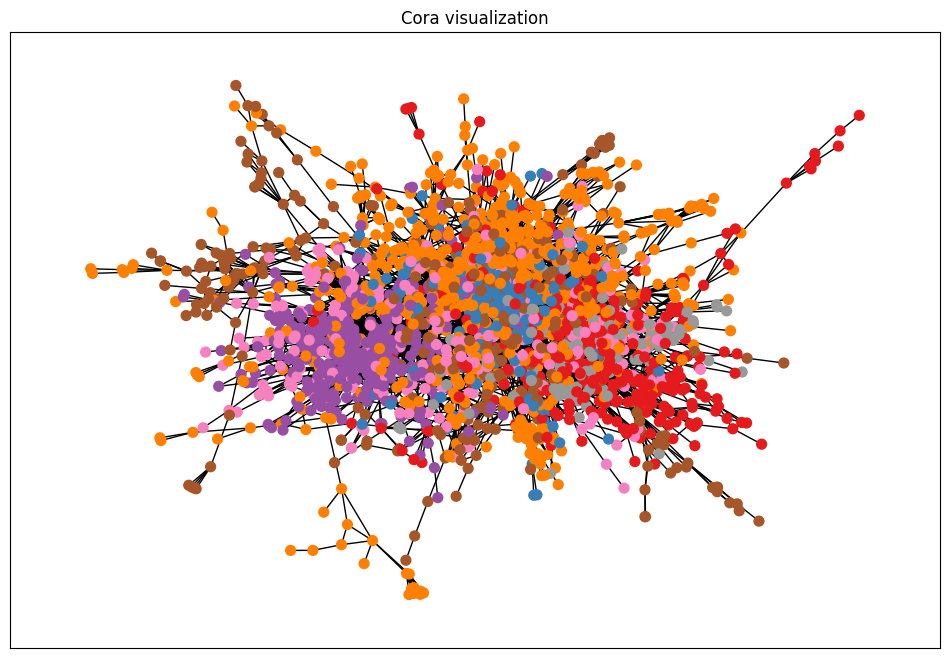

In [ ]:
# imports and initializes a dataset (e.g., Cora, CiteSeer, PubMed) with transformations
datasets_names = ["Cora", "CiteSeer", "PubMed"]

# function to load and transform the dataset
def importDataset(dataset_name, transform=None):
    pre_transform = Compose([GetLargestConnectedComponent(),
                             CustomTrainTestSplit(),
                             NormalizeFeatures()])
    # load dataset and apply transformations
    dataset = Planetoid(root='./data', name=dataset_name, transform=transform, pre_transform=pre_transform)
    data = dataset[0]
    # print dataset info
    print(f"Dataset: {dataset}"[:-2])
    print(f"Number of graphs: {len(dataset)}")
    print(f"Number of features: {dataset.x.shape[1]}")
    print(f"Number of classes: {dataset.num_classes}")
    print(f"Number of nodes: {data.num_nodes}")
    print(f"Training nodes: {data.train_mask.sum().item()}")
    print(f"Validation nodes: {data.val_mask.sum().item()}")
    print(f"Test nodes: {data.test_mask.sum().item()}")
    print(f"Dataset Description: {data}")

    return dataset.to(device)

# function to visualize the graph of the dataset
def visualizeGraph(data, title="Cora Dataset"):
    G = to_networkx(data[0], node_attrs=['y'], to_undirected=True)
    plt.figure(figsize=(12, 8))
    # get labels for nodes
    labels = [G.nodes[n]['y'] for n in G.nodes()]
    # define color map for visualization
    cmap = plt.get_cmap('Set1')
    nx.draw_networkx(
      G,
      node_color=labels,
      node_size=50,
      cmap=cmap,
      with_labels=False
    )
    plt.title(f"{str(data)[:-2]} visualization")
    plt.show()

# import and transform the dataset (first one in the list)
dataset = importDataset(datasets_names[0])
visualizeGraph(dataset)


<h2>Node Classification </h2>

Here I computed class weights for the classes of the datasets, in order to improve performance and improve generalization by making the weight of each class uniform in the loss function.

In [ ]:
# function to compute class weights based on label distribution in the dataset
def computeClassWeights(dataset, verbose=False):
    labels = dataset.y.cpu().numpy()  # convert to NumPy for easier counting
    num_classes = dataset.num_classes

    # count the occurrences of each class
    class_counts = np.bincount(labels, minlength=num_classes)

    # total number of samples
    total_samples = len(labels)

    # compute class weights for imbalanced classes
    class_weights = total_samples / (num_classes * class_counts)

    # convert class weights to PyTorch tensor
    class_weights = torch.tensor(class_weights).float().to(device)

    # calculate class imbalance ratio
    max_count = class_counts.max()
    min_count = class_counts.min()
    imbalance_ratio = max_count / min_count

    # print class distribution and imbalance info
    if verbose:
        for cls, count in enumerate(class_counts):
            print(f"Class {cls}: {count} samples")

        print(f"Maximum samples in a class: {max_count}")
        print(f"Minimum samples in a class: {min_count}")
        print(f"Imbalance ratio (max/min): {imbalance_ratio:.2f}")
        print(f"Weights for CrossEntropy: {class_weights}")
    return class_weights

# compute class weights for the dataset
class_weights = computeClassWeights(dataset, verbose=True)

# choose path based on whether class weights are used or not
use_weights = True
task_path = os.path.join(task_path, "unweighted") if not use_weights else task_path
if not os.path.exists(task_path):
    os.makedirs(task_path)


Class 0: 344 samples
Class 1: 214 samples
Class 2: 406 samples
Class 3: 726 samples
Class 4: 379 samples
Class 5: 285 samples
Class 6: 131 samples
Maximum samples in a class: 726
Minimum samples in a class: 131
Imbalance ratio (max/min): 5.54
Weights for CrossEntropy: tensor([1.0320, 1.6589, 0.8744, 0.4890, 0.9367, 1.2456, 2.7099])


Here I defined the main blocks which I used in my GNN models.
The GNN-Module is an embedding module composed by at least 2 graph convolutional layers.

The number of layers can be customized and the intermiediate layers will be composed of GNNBlock layers.

The node classifier combines the GNN-module with a final Softmax activation function to predict the label of the node.

In [ ]:
# list of available models, currently empty
models = ["GCN", "SAGE", "GAT", "DeepGCN", "DeepSAGE", "DeepGAT"]
models = []

# modular GNN block with SiLU activation and optional dropout
class GNNBlock(torch.nn.Module):
    def __init__(self, convolution, input_dim, output_dim, dropout_rate=0.5, heads=8, concat=True):
        super(GNNBlock, self).__init__()
        # configure convolution layer based on the type
        if convolution == GATConv:
            self.conv = convolution(input_dim, output_dim, heads=heads, concat=concat, dropout=dropout_rate)
            self.dropout = Identity()  # no dropout for GATConv
        else:
            self.conv = convolution(input_dim, output_dim)
            self.dropout = Identity() if dropout_rate == 0 else Dropout(dropout_rate)

        self.activation = SiLU()  # SiLU activation

    # forward pass through the GNN block
    def forward(self, x, edge_index):
        x = self.conv(x, edge_index)
        x = self.activation(x)  # apply activation
        x = self.dropout(x)  # apply dropout
        return x

# deep GNN architecture using GNNBlock layers
class GNNModule(torch.nn.Module):
    def __init__(self, convolution, input_dim, hidden_dim, num_layers, dropout_rate=0.5, heads=8, concat=True):
        super(GNNModule, self).__init__()

        self.layers = torch.nn.ModuleList()
        hidden_input = hidden_dim * heads if convolution == GATConv and concat else hidden_dim

        # stack multiple GNNBlock layers
        if num_layers > 2:
            self.layers.append(GNNBlock(convolution, input_dim, hidden_dim, dropout_rate, heads, concat))
            for _ in range(num_layers - 3):
                self.layers.append(GNNBlock(convolution, hidden_input, hidden_dim, dropout_rate, heads, concat))

        # embedding layer configuration
        embedding_input = input_dim if num_layers == 2 else hidden_input

        if convolution == GATConv:
            self.embedding = convolution(embedding_input, hidden_dim, heads=heads, concat=concat, dropout=dropout_rate)
        else:
            self.embedding = convolution(embedding_input, hidden_dim)

        self.activ = ReLU()  # ReLU activation for the embedding

    # forward pass through the entire network
    def forward(self, x, edge_index):
        for layer in self.layers:
            x = layer(x, edge_index)
        x = self.activ(self.embedding(x, edge_index))  # apply activation after embedding
        return x

# select the convolution module based on the model name
def convolution_module(model_name):
    if model_name == "GCN":
        convolution = GCNConv
    elif model_name == "SAGE":
        convolution = SAGEConv
    elif model_name == "GAT":
        convolution = GATConv
    else:
        raise ValueError(f"Unknown model name: {model_name}")
    return convolution

# node classification model combining GNN modules with final convolution layer
class NodeClassifier(torch.nn.Module):
    def __init__(self, model_name, input_dim, hidden_dim, output_dim, num_layers, dropout_rate=0.5, heads=8, concat=True):
        super(NodeClassifier, self).__init__()
        convolution = convolution_module(model_name)
        # create the embedding module based on the selected convolution type
        self.embedding = GNNModule(convolution, input_dim, hidden_dim, num_layers, dropout_rate, heads, concat)

        # final convolution layer
        if model_name == "GAT":
            hidden_input = hidden_dim * heads if concat else hidden_dim
            self.last_conv = convolution(hidden_input, output_dim, heads=1, concat=False, dropout=dropout_rate)
            self.dropout = Identity()  # no dropout for GATConv output
        else:
            self.last_conv = convolution(hidden_dim, output_dim)
            self.dropout = Dropout(dropout_rate) if dropout_rate > 0 else Identity()

        self.softmax = LogSoftmax(dim=1)  # softmax output for classification

    # forward pass, optionally return embeddings before the final classification
    def forward(self, x, edge_index, return_embeddings=False):
        x = self.embedding(x, edge_index)
        if return_embeddings:
            return x  # return embeddings if requested
        x = self.dropout(self.last_conv(x, edge_index))  # apply final convolution and dropout
        return self.softmax(x)  # apply softmax for class probabilities


The following class helped me training the models and testing them on all three datasets.

In [ ]:
# this class handles training, validation, and testing of GNN models for node classification
# it also supports re-importing pretrained models and testing them on any dataset or input mask
class TrainerNodeClassification:
    def __init__(self, model, optimizer, criterion, train_dataset):
        self.model = model  # the GNN model
        self.optimizer = optimizer  # optimizer for training
        self.criterion = criterion  # loss function
        self.train_dataset = train_dataset  # training dataset

        # initialize metrics (accuracy, precision, recall, f1, auc) for the training dataset
        self.metrics = {
            "accuracy": Accuracy(task="multiclass", num_classes=train_dataset.num_classes).to(device),
            "precision": Precision(task="multiclass", num_classes=train_dataset.num_classes, average='weighted').to(device),
            "recall": Recall(task="multiclass", num_classes=train_dataset.num_classes, average='weighted').to(device),
            "f1": F1Score(task="multiclass", num_classes=train_dataset.num_classes, average='weighted').to(device),
            "auc": AUROC(task="multiclass", num_classes=train_dataset.num_classes, average='weighted').to(device),
        }

    def fit(self, epochs=200, plot=False):
        """Train the model on the training dataset."""
        data = self.train_dataset[0]  # get the first data point from the dataset

        self.model.train()  # set the model to training mode
        metrics_history = defaultdict(list) if plot else None  # initialize history for plotting

        for epoch in range(epochs):
            self.optimizer.zero_grad()  # reset gradients

            # Forward pass
            out = self.model(data.x, data.edge_index)

            # Compute the loss using the train_mask to focus on training nodes
            loss = self.criterion(out[data.train_mask], data.y[data.train_mask])
            loss.backward()  # backpropagate gradients
            self.optimizer.step()  # update the model parameters

            if plot:
                metrics_history["loss"].append(loss.item())  # store loss for plotting
                metrics = self.test(self.train_dataset, mask=data.test_mask)  # evaluate on test mask
                for key, value in metrics.items():
                    metrics_history[key].append(value)  # store metrics for plotting
                self.model.train()  # ensure model stays in training mode after evaluation

        if plot:
            return metrics_history  # return metrics history if plotting is enabled

    def validate(self):
        """Validate the model on the validation set."""
        data = self.train_dataset[0]
        return self.test(self.train_dataset, mask=data.val_mask)  # evaluate on the validation mask

    def test(self, dataset=None, mask=None):
        """Test the model on the given dataset using initialized metrics."""
        dataset = self.train_dataset if dataset is None else dataset  # use train dataset by default
        data = dataset[0]

        # Default to test_mask if no mask is provided
        mask = data.test_mask if mask is None else mask

        # Create new metrics if the number of classes is different
        if dataset.num_classes != self.train_dataset.num_classes:
            metrics = {
                "accuracy": Accuracy(task="multiclass", num_classes=dataset.num_classes).to(device),
                "precision": Precision(task="multiclass", num_classes=dataset.num_classes, average='weighted').to(device),
                "recall": Recall(task="multiclass", num_classes=dataset.num_classes, average='weighted').to(device),
                "f1": F1Score(task="multiclass", num_classes=dataset.num_classes, average='weighted').to(device),
                "auc": AUROC(task="multiclass", num_classes=dataset.num_classes, average='weighted').to(device),
            }
        else:
            metrics = self.metrics  # use existing metrics if class count is the same

        self.model.eval()  # set the model to evaluation mode
        results = {}
        with torch.no_grad():  # no need to track gradients during evaluation
            out = self.model(data.x, data.edge_index)  # model forward pass
            pred = out.argmax(dim=1)  # get predicted class labels
            prob = torch.exp(out)  # compute class probabilities (softmax)
            # Select the subset based on the mask
            test_labels = data.y[mask]  # ground truth labels for test nodes
            test_pred = pred[mask]  # predicted labels for test nodes
            test_prob = prob[mask]  # predicted probabilities for test nodes
            # Update metrics based on the mask
            for name, metric in metrics.items():
                if name == "auc":
                    metric.update(test_prob, test_labels)  # update AUC metric with probabilities
                else:
                    metric.update(test_pred, test_labels)  # update other metrics with predictions

                # compute and store metrics
                results[name] = metric.compute().item()
                # reset metrics after computation
                metric.reset()

        return results  # return computed metrics

best_params = {}  # store the best model parameters



Grid search to find the best hyperparameters for the models (adapted also for link prediction).


In [ ]:
def getTrainer(task, model_name, params_dict, input):
    if task == "NC":
        # create node classifier with specified parameters
        model = NodeClassifier(model_name,
                               input_dim=input.num_features,
                               hidden_dim=params_dict['hidden_dim'],
                               output_dim=input.num_classes,
                               num_layers=params_dict['num_layers'],
                               dropout_rate=params_dict["dropout_rate"],
                               heads=params_dict.get("heads", 8),
                               concat=params_dict.get("concat", False)).to(device)
        # set optimizer with learning rate and weight decay
        optimizer = Adam(model.parameters(), lr=params_dict['lr'], weight_decay=params_dict['weight_decay'])
        # set criterion with optional class weights
        criterion = NLLLoss(weight=class_weights) if use_weights else NLLLoss()
        # create trainer for node classification
        trainer = TrainerNodeClassification(model, optimizer, criterion, dataset)
        return trainer

    elif task == "LP":
        # set input dimensions for link prediction
        input_dim = input["train"].num_features
        # create link predictor with specified parameters
        model = LinkPredictor(model_name,
                              input_dim=input_dim,
                              hidden_dim=params_dict['hidden_dim'],
                              output_dim=params_dict['output_dim'],
                              num_layers=params_dict['num_layers'],
                              dropout_rate=params_dict["dropout_rate"],
                              heads=params_dict.get("heads", 8),
                              concat=params_dict.get("concat", False),
                              mode=params_dict['mode']).to(device)
        # set optimizer with learning rate and weight decay
        optimizer = Adam(model.parameters(), lr=params_dict['lr'], weight_decay=params_dict['weight_decay'])
        # set binary cross-entropy loss for link prediction
        criterion = BCELoss()
        # create trainer for link prediction
        trainer = TrainerLinkPrediction(model, optimizer, criterion, input)
        return trainer
    else:
        # raise error for unsupported task type
        raise ValueError(f"Unknown task: {task}")

def gridSearch(param_grid, model_name, dataset, task="NC"):

    # generate all combinations of hyperparameters
    param_combinations = list(itertools.product(*param_grid.values()))
    param_names = list(param_grid.keys())

    # initialize variables to track best results
    best_auc = None
    best_params = None

    for params in param_combinations:

        # map each hyperparameter combination to a dictionary
        params_dict = dict(zip(param_names, params))
        print(f"Training {model_name} with {params_dict}")

        # initialize trainer and train model
        trainer = getTrainer(task, model_name, params_dict, dataset)

        # train and evaluate the model
        trainer.fit(epochs=params_dict['epochs'])
        results = trainer.validate()
        auc = results["auc"]

        # check if this combination gives the best validation AUC
        if best_auc is None or auc > best_auc:
            best_auc = auc
            best_params = params_dict

    print(f"Best hyperparameters for {model_name}: {best_params} with validation ROC-AUC: {best_auc:.4f}")
    return best_params

for model in models:
    # define hyperparameter search space for each model
    num_layers = [3, 5, 10, 50] if model.startswith("Deep") else [2]
    param_grid = {
        'lr': [0.1, 0.01, 0.001],          # learning rates to test
        'hidden_dim': [32, 64, 128],       # hidden dimension sizes to test
        'weight_decay': [1e-4, 1e-5, 1e-6],# weight decay options for regularization
        'epochs': [20, 50, 100],           # number of training epochs to test
        'dropout_rate': [0, 0.25, 0.5, 0.75],  # dropout rates to test
        'num_layers': num_layers           # number of layers to test
    }

    if model.endswith("GAT"):
         # specific grid search settings for GAT model
         param_grid = {
            'lr': [0.1, 0.01, 0.001],
            'hidden_dim': [32, 64],
            'weight_decay': [1e-4, 1e-5],
            'epochs': [20, 50, 100],
            'dropout_rate': [0, 0.5],
            'num_layers': num_layers[:-1] if model.startswith("Deep") else num_layers,
            'heads': [16, 32],                # GAT-specific: number of attention heads
            'concat': [True, False]           # GAT-specific: whether to concatenate heads
        }

    # perform grid search for the best hyperparameters
    best_params[model] = gridSearch(param_grid, model.replace("Deep", ""), dataset)


Here I tested the performance of the models, after training them with the best hyperparameters.

In [ ]:
def plotMetrics(metrics, model_path):
    for i, (metric_name, metric_values) in enumerate(metrics.items()):
        # plot each metric value against epochs
        plt.plot(metric_values, label=metric_name, color=colors[i % len(colors)])
        plt.xlabel('epochs')
        plt.ylabel(metric_name)
        plt.legend()
        plt.title(f'{metric_name} evolution during training')
        # save the plot as a PNG image in the model's directory
        plt.savefig(os.path.join(model_path, f'{metric_name}.png'))
        plt.show()

best_models = {}
best_performances = defaultdict(lambda: {})

for model_name, best_hypers in best_params.items():
    # create model using best hyperparameters
    model = NodeClassifier(model_name.replace("Deep", ""),
                           input_dim=dataset.num_features,
                           hidden_dim=best_hypers["hidden_dim"],
                           output_dim=dataset.num_classes,
                           num_layers=best_hypers["num_layers"],
                           dropout_rate=best_hypers["dropout_rate"],
                           heads=best_hypers.get("heads", 8),
                           concat=best_hypers.get("concat", False)).to(device)

    # set optimizer and loss function
    optimizer = Adam(model.parameters(), lr=best_hypers["lr"], weight_decay=best_hypers["weight_decay"])
    criterion = NLLLoss(weight=class_weights) if use_weights else NLLLoss()

    # define path to store model and metrics
    model_path = os.path.join(task_path, f'{model_name}')

    # create the model's directory if it doesn't exist
    if not os.path.exists(model_path):
        os.makedirs(model_path)

    # save the best hyperparameters to a JSON file
    with open(os.path.join(model_path, 'best_hypers.json'), 'w') as f:
        json.dump(best_hypers, f, indent=4)

    # initialize and train the model
    trainer = TrainerNodeClassification(model, optimizer, criterion, dataset)
    metrics = trainer.fit(epochs=best_hypers["epochs"], plot=True)

    # plot and save the metrics for each model
    plotMetrics(metrics, model_path)

    # save the trained model weights
    torch.save(model.state_dict(), os.path.join(model_path, 'best_model.pth'))

    # test the model and print results
    results = trainer.test()
    acc, prec, rec, f1, auc = results.values()
    print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")
    dataset_name = str(dataset)[:-2]
    best_performances[model_name][dataset_name] = results
    best_models[model_name] = trainer.model


With this function we can reload our models (adapted also for link prediction).

In [ ]:
load_models = ["GCN", "SAGE", "GAT", "DeepGCN", "DeepSAGE", "DeepGAT"]

def loadModel(model_name, task="NC"):
    # define path to load model and hyperparameters
    model_path = os.path.join(task_path, f'{model_name}')
    # load best hyperparameters from JSON file
    with open(os.path.join(model_path, 'best_hypers.json'), 'r') as f:
        best_hypers = json.load(f)
    best_params[model_name] = best_hypers
    # create the model based on task type and loaded hyperparameters
    if task == "NC":
        model = NodeClassifier(model_name.replace("Deep", ""),
                               input_dim=dataset.num_features,
                               hidden_dim=best_hypers["hidden_dim"],
                               output_dim=dataset.num_classes,
                               num_layers=best_hypers["num_layers"],
                               dropout_rate=best_hypers["dropout_rate"],
                               heads=best_hypers.get("heads", 8),
                               concat=best_hypers.get("concat", False)).to(device)
    elif task == "LP":
        model = LinkPredictor(model_name.replace("Deep", ""),
                               input_dim=dataset.num_features,
                               hidden_dim=best_hypers["hidden_dim"],
                               output_dim=best_hypers["output_dim"],
                               num_layers=best_hypers["num_layers"],
                               dropout_rate=best_hypers["dropout_rate"],
                               heads=best_hypers.get("heads", 8),
                               concat=best_hypers.get("concat", False),
                               mode=best_hypers["mode"]).to(device)
    else:
        raise ValueError(f"Unknown task: {task}")

    # load model weights from saved file
    model.load_state_dict(torch.load(os.path.join(model_path, 'best_model.pth'), map_location=device, weights_only=True))
    return model

for model_name in load_models:
    # load model and save to best_models dictionary
    model = loadModel(model_name)
    best_models[model_name] = model

    # initialize the trainer and test the model
    trainer = TrainerNodeClassification(model, optimizer=None, criterion=None, train_dataset=dataset)
    results = trainer.test()
    acc, prec, rec, f1, auc = results.values()

    # store the test results for the model
    dataset_name = str(dataset)[:-2]
    best_performances[model_name][dataset_name] = results
    # print performance metrics
    print(f"Loaded {model_name} on {dataset_name}")
    print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")


Loaded GCN on Cora
Accuracy: 0.8612, Precision: 0.8718, Recall: 0.8612, F1: 0.8628, AUC: 0.9830
Loaded SAGE on Cora
Accuracy: 0.8672, Precision: 0.8766, Recall: 0.8672, F1: 0.8681, AUC: 0.9854
Loaded GAT on Cora
Accuracy: 0.8652, Precision: 0.8786, Recall: 0.8652, F1: 0.8669, AUC: 0.9845
Loaded DeepGCN on Cora
Accuracy: 0.8612, Precision: 0.8737, Recall: 0.8612, F1: 0.8638, AUC: 0.9801
Loaded DeepSAGE on Cora
Accuracy: 0.8571, Precision: 0.8630, Recall: 0.8571, F1: 0.8579, AUC: 0.9808
Loaded DeepGAT on Cora
Accuracy: 0.8551, Precision: 0.8631, Recall: 0.8551, F1: 0.8564, AUC: 0.9818


In [ ]:
best_models

{'GCN': NodeClassifier(
   (embedding): GNNModule(
     (layers): ModuleList()
     (embedding): GCNConv(1433, 32)
     (activ): ReLU()
   )
   (last_conv): GCNConv(32, 7)
   (dropout): Dropout(p=0.25, inplace=False)
   (softmax): LogSoftmax(dim=1)
 ),
 'SAGE': NodeClassifier(
   (embedding): GNNModule(
     (layers): ModuleList()
     (embedding): SAGEConv(1433, 32, aggr=mean)
     (activ): ReLU()
   )
   (last_conv): SAGEConv(32, 7, aggr=mean)
   (dropout): Dropout(p=0.75, inplace=False)
   (softmax): LogSoftmax(dim=1)
 ),
 'GAT': NodeClassifier(
   (embedding): GNNModule(
     (layers): ModuleList()
     (embedding): GATConv(1433, 64, heads=16)
     (activ): ReLU()
   )
   (last_conv): GATConv(1024, 7, heads=1)
   (dropout): Identity()
   (softmax): LogSoftmax(dim=1)
 ),
 'DeepGCN': NodeClassifier(
   (embedding): GNNModule(
     (layers): ModuleList(
       (0): GNNBlock(
         (conv): GCNConv(1433, 64)
         (dropout): Dropout(p=0.75, inplace=False)
         (activation): Si

<h2> Generalization on other datasets </h2>

Here I defined a transformation that rescales the features to an increased or reduced feature space using the required method and the provided target dimension.

In [ ]:
class AdaptDim(BaseTransform):
    # adjust the dimensionality of the features in the dataset
    def __init__(self, target_dim, method="svd"):
        self.target_dim = target_dim
        self.method = method

    # adjust the features depending on whether the current dimension is larger or smaller than the target
    def __call__(self, data):
        if data.num_features > self.target_dim:
            data = self.reduce_dim(data)
        elif data.num_features < self.target_dim:
            data = self.increase_dim(data)

        return data.to(device)

    # reduce features using SVD or random projection
    def reduce_dim(self, data):
        features = data.x
        if self.method == "svd":
            U, S, Vt = torch.linalg.svd(features, full_matrices=False)
            # use top target_dim dimensions
            reduced_features = torch.mm(features, Vt[:self.target_dim, :].T)
        elif self.method == "random_projection":
            transformer = GaussianRandomProjection(n_components=self.target_dim)
            reduced_features = torch.tensor(transformer.fit_transform(features.cpu().numpy()))
        else:
            raise ValueError("Invalid method. Choose 'svd' or 'random_projection'.")
        data.x = reduced_features
        return data

    # increase features using zero-padding or random projection
    def increase_dim(self, data):
        features = data.x
        num_samples, original_dim = features.size()

        if self.method == "zero_padding":
            # fill feature space with zero padding
            padding = torch.zeros((num_samples, self.target_dim - original_dim))
            increased_features = torch.cat((features.cpu(), padding), dim=1)

        elif self.method == "random_projection":
            # project to higher dimensional space
            transformer = GaussianRandomProjection(n_components=self.target_dim)
            increased_features = torch.tensor(transformer.fit_transform(features.cpu().numpy()))
        else:
            raise ValueError("Invalid method. Choose 'zero_padding' or 'random_projection'.")
        data.x = increased_features
        return data


I imported the CiteSeer and PubMed datasets with dimensionality reduction and augmentation of the feature spaces to test how the models generalize on them.

In [ ]:
# load CiteSeer and PubMed datasets
datasets = []
# dimensionality reduction / augmentation techniques for the datasets
methods = ["random_projection", "zero_padding"]
for i, datataset_name in enumerate(datasets_names[1:]):
    data = importDataset(datataset_name, AdaptDim(dataset.num_features, method=methods[i]))
    datasets.append(data)


Processing...


Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])
Original Data: 3327 nodes, 9104 edges
Largest Connected Component: 2120 nodes, 3679 edges
Converted Back Data: 2120 nodes, 7358 edges


Done!


Dataset: CiteSeer
Number of graphs: 1
Number of features: 3703
Number of classes: 6
Number of nodes: 2120
Training nodes: 1272
Validation nodes: 424
Test nodes: 424
Dataset Description: Data(x=[2120, 1433], edge_index=[2, 7358], y=[2120], train_mask=[2120], val_mask=[2120], test_mask=[2120])


Processing...


Data(x=[19717, 500], edge_index=[2, 88648], y=[19717], train_mask=[19717], val_mask=[19717], test_mask=[19717])
Original Data: 19717 nodes, 88648 edges
Largest Connected Component: 19717 nodes, 44324 edges
Converted Back Data: 19717 nodes, 88648 edges


Done!


Dataset: PubMed
Number of graphs: 1
Number of features: 500
Number of classes: 3
Number of nodes: 19717
Training nodes: 11830
Validation nodes: 3943
Test nodes: 3944
Dataset Description: Data(x=[19717, 1433], edge_index=[2, 88648], y=[19717], train_mask=[19717], val_mask=[19717], test_mask=[19717])


The Cora dataset has 7 classes, which is also the dimensionality of the last convolutional layer of the model. Instead of guessing some mapping between the classes, I reduced the dimensions of the weights to the number of classes of the required datset (6 for CiteSeer and 3 for PubMed) using SVD.

Notice: for some reason, the shape of the weights of the last layer was transposed.

In [ ]:
def reduceLastGNNLayer(model, new_output_dim):
    # recover the parameters of the last GAT layer
    gat_params = recoverParamsGAT(model.last_conv)

    # access the last layer of the GNN model
    last_layer = model.last_conv

    # extract the weight and bias of the last layer, depending on the layer type
    if isinstance(last_layer, GCNConv) or isinstance(last_layer, GATConv):
        weight = last_layer.lin.weight  # weight matrix with shape: (output_dim, input_dim)
        bias = last_layer.lin.bias      # bias vector with shape: (output_dim), if applicable
    elif isinstance(last_layer, SAGEConv):
        weight = last_layer.lin_l.weight  # weight matrix with shape: (output_dim, input_dim)
        bias = last_layer.lin_l.bias      # bias vector with shape: (output_dim), if applicable

    # apply singular value decomposition (SVD) to the weight matrix
    U, S, Vt = torch.linalg.svd(weight, full_matrices=False)  # U, S, Vt have shapes: U(output_dim, output_dim), S(output_dim), Vt(output_dim, input_dim)

    # project the weight matrix onto a lower-dimensional space based on new_output_dim
    projected_weight = torch.mm(U[:, :new_output_dim].T, weight)  # resulting weight shape: (new_output_dim, input_dim)

    # if bias exists, truncate it to match the new output dimension, otherwise set to None
    if bias is not None:
        new_bias = bias[:new_output_dim]
    else:
        new_bias = None

    # create a new instance of the last layer with the updated output dimension
    new_last_layer = last_layer.__class__(
        in_channels=last_layer.in_channels,
        out_channels=new_output_dim,
        **gat_params
    )

    # update the new layer's weight and bias
    if isinstance(last_layer, GCNConv) or isinstance(last_layer, GATConv):
        # set the weight and bias for the new layer
        new_last_layer.lin.weight.data = projected_weight  # shape: (new_output_dim, input_dim)
        if new_bias is not None:
            new_last_layer.lin.bias.data = new_bias
    elif isinstance(last_layer, SAGEConv):
        # set the weight and bias for the new layer
        new_last_layer.lin_l.weight.data = projected_weight  # shape: (new_output_dim, input_dim)
        if new_bias is not None:
            new_last_layer.lin_l.bias.data = new_bias

    # replace the last layer in the model with the updated one
    model.last_conv = new_last_layer

    # return the updated model
    return model.to(device)

def recoverParamsGAT(layer):
    # recover GAT-specific parameters
    gat_params = {}
    if hasattr(layer, 'heads'):
        gat_params['heads'] = layer.heads
    if hasattr(layer, 'concat'):
        gat_params['concat'] = layer.concat
    if hasattr(layer, 'dropout'):
        gat_params['dropout'] = layer.dropout
    return gat_params


Here I tested the models on CiteSeer and PubMed.

In [ ]:
def evaluateModel(model, data, train_dataset=dataset):
    # initialize the TrainerNodeClassification with the adjusted model
    trainer = TrainerNodeClassification(model, optimizer=None, criterion=None, train_dataset=train_dataset)

    # test the model on the required dataset
    results = trainer.test(data, mask=np.ones(data.x.shape[0], dtype=bool))
    return results

performances = defaultdict(lambda: {})
for model_name, model in best_models.items():
    for data in datasets:
        dataset_name = str(data)[:-2]
        model = reduceLastGNNLayer(deepcopy(model), data.num_classes)
        print(f"Evaluating {model_name} on {dataset_name}")
        results = evaluateModel(model, data)
        performances[model_name][dataset_name] = results
        acc, prec, rec, f1, auc = results.values()
        print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")



Evaluating GCN on CiteSeer
Accuracy: 0.1755, Precision: 0.1233, Recall: 0.1755, F1: 0.1439, AUC: 0.4617
Evaluating GCN on PubMed
Accuracy: 0.3935, Precision: 0.3295, Recall: 0.3935, F1: 0.2504, AUC: 0.5061
Evaluating SAGE on CiteSeer
Accuracy: 0.1269, Precision: 0.1661, Recall: 0.1269, F1: 0.0678, AUC: 0.5190
Evaluating SAGE on PubMed
Accuracy: 0.2757, Precision: 0.3827, Recall: 0.2757, F1: 0.2265, AUC: 0.5260
Evaluating GAT on CiteSeer
Accuracy: 0.1877, Precision: 0.1836, Recall: 0.1877, F1: 0.1331, AUC: 0.4743
Evaluating GAT on PubMed
Accuracy: 0.3972, Precision: 0.3466, Recall: 0.3972, F1: 0.2374, AUC: 0.5433
Evaluating DeepGCN on CiteSeer
Accuracy: 0.2316, Precision: 0.3170, Recall: 0.2316, F1: 0.1685, AUC: 0.5961
Evaluating DeepGCN on PubMed
Accuracy: 0.4343, Precision: 0.4258, Recall: 0.4343, F1: 0.3795, AUC: 0.5677
Evaluating DeepSAGE on CiteSeer
Accuracy: 0.1830, Precision: 0.0335, Recall: 0.1830, F1: 0.0566, AUC: 0.4481
Evaluating DeepSAGE on PubMed
Accuracy: 0.3610, Precision

In [ ]:
# updates and stores new performance values, based on AUC
def updatePerformances(best_performances, performnces, methods):
    for model_name, model_performances in performances.items():
        one_update = False
        for i, (dataset_name, dataset_performance) in enumerate(model_performances.items()):
            if dataset_name not in best_performances[model_name] or best_performances[model_name][dataset_name]['auc'] < dataset_performance['auc']:
                print(f"Updating performances for {model_name} on {dataset_name} with method {methods[i]}")
                best_performances[model_name][dataset_name] = dataset_performance
                best_performances[model_name][dataset_name] = dataset_performance
                best_performances[model_name][dataset_name]['method'] = methods[i]
                one_update = True
        if one_update:
            for model_name in best_performances:
                model_path = os.path.join(task_path, f'{model_name}')
                with open(os.path.join(model_path, 'performances.json'), 'w') as f:
                    json.dump(best_performances[model_name], f, indent=4)

updatePerformances(best_performances, performances, methods)

The following function replaces the first and last layer of the models of the networks with two new layers with different dimensions. Moreover, it freezes the weights of the intermediate layers. The resulting models are ready for the retraining of their initial and final layers.

In [ ]:
def adaptModel(model, new_input_dim, new_output_dim):

    # freeze all model parameters initially
    for param in model.parameters():
        param.requires_grad = False

    if len(model.embedding.layers) > 0:
        # adjust the first layer for deep models (with multiple layers)
        first_layer = model.embedding.layers[0].conv
        gat_params = recoverParamsGAT(first_layer)
        model.embedding.layers[0].conv = first_layer.__class__(
            in_channels=new_input_dim,
            out_channels=first_layer.out_channels,
            **gat_params
        )
        # enable training for the new first layer
        for param in model.embedding.layers[0].conv.parameters():
            param.requires_grad = True
    else:
        # adjust the first layer for non-deep models (with single embedding layer)
        first_layer = model.embedding.embedding
        gat_params = recoverParamsGAT(first_layer)
        model.embedding.embedding = first_layer.__class__(
            in_channels=new_input_dim,
            out_channels=first_layer.out_channels,
            **gat_params
        )
        # enable training for the new first layer
        for param in model.embedding.embedding.parameters():
            param.requires_grad = True

    # adjust the second (output) layer for all models
    last_layer = model.last_conv
    gat_params = recoverParamsGAT(last_layer)
    model.last_conv = last_layer.__class__(
        in_channels=last_layer.in_channels,
        out_channels=new_output_dim,
        **gat_params
    )
    # enable training for the new last layer
    for param in model.last_conv.parameters():
        param.requires_grad = True

    return model.to(device)


In [ ]:
def checkRequiresGrad(model):
    print("Parameters and their requires_grad status:")
    for name, param in model.named_parameters():
        print(f"{name}: requires_grad={param.requires_grad}")

model = deepcopy(best_models["DeepGCN"])

adj = adaptModel(model, 16, 24)
checkRequiresGrad(adj)
print(adj)


Parameters and their requires_grad status:
embedding.layers.0.conv.bias: requires_grad=True
embedding.layers.0.conv.lin.weight: requires_grad=True
embedding.embedding.bias: requires_grad=False
embedding.embedding.lin.weight: requires_grad=False
last_conv.bias: requires_grad=True
last_conv.lin.weight: requires_grad=True
NodeClassifier(
  (embedding): GNNModule(
    (layers): ModuleList(
      (0): GNNBlock(
        (conv): GCNConv(16, 64)
        (dropout): Dropout(p=0.75, inplace=False)
        (activation): SiLU()
      )
    )
    (embedding): GCNConv(64, 64)
    (activ): ReLU()
  )
  (last_conv): GCNConv(64, 24)
  (dropout): Dropout(p=0.75, inplace=False)
  (softmax): LogSoftmax(dim=1)
)


In [ ]:
# load CiteSeer and PubMed datasets with no dimensionality reduction/augmentation
datasets = []
# retrain models on CiteSeer and PubMed
methods = ["retrain", "retrain"]
for i, datataset_name in enumerate(datasets_names[1:]):
    data = importDataset(datataset_name)
    datasets.append(data.to(device))


Dataset: CiteSeer
Number of graphs: 1
Number of features: 3703
Number of classes: 6
Number of nodes: 2120
Training nodes: 1272
Validation nodes: 424
Test nodes: 424
Dataset Description: Data(x=[2120, 3703], edge_index=[2, 7358], y=[2120], train_mask=[2120], val_mask=[2120], test_mask=[2120])
Dataset: PubMed
Number of graphs: 1
Number of features: 500
Number of classes: 3
Number of nodes: 19717
Training nodes: 11830
Validation nodes: 3943
Test nodes: 3944
Dataset Description: Data(x=[19717, 500], edge_index=[2, 88648], y=[19717], train_mask=[19717], val_mask=[19717], test_mask=[19717])


Here I retrained the first and last layers of the models and evaluated them on CiteSeer and PubMed

In [ ]:
def retrainAndEvaluateModel(model, data, best_hypers):
    # initialize the optimizer with the learning rate and weight decay from best hyperparameters
    optimizer = Adam(model.parameters(), lr=best_hypers["lr"], weight_decay=best_hypers["weight_decay"])

    # set up the loss function; use class weights if specified
    if use_weights:
        class_weights = computeClassWeights(data)
        criterion = NLLLoss(weight=class_weights)
    else:
        criterion = NLLLoss()

    # do not modify original model: copy it before modifying
    adj = adaptModel(deepcopy(model).to(device), data.num_features, data.num_classes)

    # initialize the trainer with the modified model, optimizer, criterion, and dataset
    trainer = TrainerNodeClassification(adj, optimizer, criterion, data)
    trainer.fit(epochs=best_hypers["epochs"])

    # evaluate the model and return results
    results = trainer.test()
    return results

performances = defaultdict(lambda: {})

for model_name, model in best_models.items():
    for data in datasets:
        dataset_name = str(data)[:-2]
        print(f"Evaluating {model_name} on {dataset_name}")

        # retrain and evaluate the model on the dataset
        results = retrainAndEvaluateModel(model, data, best_params[model_name])

        performances[model_name][dataset_name] = results
        acc, prec, rec, f1, auc = results.values()

        print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")

# update performance results with the new evaluations
updatePerformances(best_performances, performances, methods)


Evaluating GCN on CiteSeer
Accuracy: 0.1722, Precision: 0.1938, Recall: 0.1722, F1: 0.1415, AUC: 0.5285
Evaluating GCN on PubMed
Accuracy: 0.2320, Precision: 0.5053, Recall: 0.2320, F1: 0.1451, AUC: 0.5717
Evaluating SAGE on CiteSeer
Accuracy: 0.1486, Precision: 0.0221, Recall: 0.1486, F1: 0.0384, AUC: 0.5109
Evaluating SAGE on PubMed
Accuracy: 0.3988, Precision: 0.2773, Recall: 0.3988, F1: 0.2476, AUC: 0.4740
Evaluating GAT on CiteSeer
Accuracy: 0.1792, Precision: 0.1200, Recall: 0.1792, F1: 0.1155, AUC: 0.4758
Evaluating GAT on PubMed
Accuracy: 0.4138, Precision: 0.3691, Recall: 0.4138, F1: 0.3192, AUC: 0.5562
Evaluating DeepGCN on CiteSeer
Accuracy: 0.2736, Precision: 0.1272, Recall: 0.2736, F1: 0.1724, AUC: 0.5033
Evaluating DeepGCN on PubMed
Accuracy: 0.4021, Precision: 0.1617, Recall: 0.4021, F1: 0.2307, AUC: 0.4700
Evaluating DeepSAGE on CiteSeer
Accuracy: 0.1863, Precision: 0.0347, Recall: 0.1863, F1: 0.0585, AUC: 0.4341
Evaluating DeepSAGE on PubMed
Accuracy: 0.3887, Precision

In [ ]:
best_performances

defaultdict(<function __main__.<lambda>()>,
            {'GCN': {'Cora': {'accuracy': 0.8611670136451721,
               'precision': 0.8717867136001587,
               'recall': 0.8611669540405273,
               'f1': 0.8627865314483643,
               'auc': 0.9829511046409607},
              'CiteSeer': {'accuracy': 0.28584906458854675,
               'precision': 0.19768784940242767,
               'recall': 0.28584906458854675,
               'f1': 0.203191339969635,
               'auc': 0.5061997175216675,
               'method': 'svd'},
              'PubMed': {'accuracy': 0.37905678153038025,
               'precision': 0.38436976075172424,
               'recall': 0.37905681133270264,
               'f1': 0.36517399549484253,
               'auc': 0.5229231119155884,
               'method': 'retrain'}},
             'SAGE': {'Cora': {'accuracy': 0.8672032356262207,
               'precision': 0.8766447901725769,
               'recall': 0.8672032356262207,
               '

<h2>Node2Vec</h2>

Here I implemented a class to train Node2Vec Embeddings and a Logistic Regression model to perform classification on Node2Vec embeddings.

The last class basically deals with Node2Vec and Logistic Regression models storage/loading for the node classifier and link predictor.

In [ ]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()

        if output_dim == 2:
            # for binary classification, use a single output with sigmoid activation
            self.linear = Linear(input_dim, 1)
            self.activ = Sigmoid()
        else:
            # for multi-class classification, use softmax activation
            self.linear = Linear(input_dim, output_dim)
            self.activ = LogSoftmax(dim=1)

    def forward(self, x):
        return self.activ(self.linear(x))


class Node2VecEmbeddings:
    def __init__(self, train_dataset, params):
        self.data = train_dataset[0]
        self.params = params

        # initialize Node2Vec model with specified parameters
        self.node2vec = Node2Vec(
            self.data.edge_index,
            embedding_dim=params['embedding_dim'],
            walk_length=params.get('walk_length', 20),
            context_size=params.get('context_size', 10),
            walks_per_node=params.get('walks_per_node', 1),
            num_negative_samples=params.get('num_negative_samples', 1),
            p=params['p'],
            q=params['q'],
            sparse=True,
        ).to(device)

        # prepare the data loader for Node2Vec training
        self.loader = self.node2vec.loader(batch_size=params['batch_size'], shuffle=True)
        self.optimizer_node2vec = SparseAdam(list(self.node2vec.parameters()), lr=params['node2vec_lr'])

    def train_node2vec(self):
        self.node2vec.train()
        total_loss = 0
        # iterate through the data loader and train Node2Vec
        for pos_rw, neg_rw in self.loader:
            self.optimizer_node2vec.zero_grad()

            # compute the loss for the current batch
            loss = self.node2vec.loss(pos_rw.to(device), neg_rw.to(device))
            loss.backward()
            self.optimizer_node2vec.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(self.loader)
        return avg_loss

    def get_embeddings(self):
        self.node2vec.eval()
        with torch.no_grad():
            embeddings = self.node2vec()
        return embeddings.detach()


class Node2VecBase:
    def __init__(self, dataset, params):
        self.node2vec = Node2VecEmbeddings(dataset, params)
        self.params = params
        self.model = None

    def save_model(self, path):
        if self.model is not None:
            # save both the model's state dict and the Node2Vec model's state dict
            torch.save({
                'model_state_dict': self.model.state_dict(),
                'node2vec_state_dict': self.node2vec.node2vec.state_dict(),
            }, path)
        else:
            print("Model is not trained yet, cannot save.")

    def load_model(self, path):
        # load the saved checkpoint
        checkpoint = torch.load(path, map_location=device, weights_only=True)
        self.node2vec.node2vec.load_state_dict(checkpoint['node2vec_state_dict'])

        # recreate the model and load its state_dict
        self.model = self.create_model()
        self.model.load_state_dict(checkpoint['model_state_dict'])

    def create_model(self):
        # this method should be implemented in subclasses to return the appropriate model
        raise NotImplementedError("Subclasses must implement this method.")


The Node2Vec node classifier trains the embeddings and evaluates them for the task using logistic regression. Moreover, it stops training as soon as embeddings do not improve anymore.

In [ ]:
def early_stopping(value, best_value, counter, patience):
    if value > best_value:
        best_value = value
        counter = 0
    else:
        counter += 1
    return counter >= patience, best_value, counter

class Node2VecNodeClassifier(Node2VecBase):
    def __init__(self, dataset, params):
        super().__init__(dataset, params)
        self.num_classes = dataset.num_classes

        # initialize the metrics for classification evaluation
        self.metrics = {
            "accuracy": Accuracy(task="multiclass", num_classes=dataset.num_classes).to(device),
            "precision": Precision(task="multiclass", num_classes=dataset.num_classes, average='weighted').to(device),
            "recall": Recall(task="multiclass", num_classes=dataset.num_classes, average='weighted').to(device),
            "f1": F1Score(task="multiclass", num_classes=dataset.num_classes, average='weighted').to(device),
            "auc": AUROC(task="multiclass", num_classes=dataset.num_classes, average='weighted').to(device),
        }

    def fit(self, epochs_n2v, epochs_lr, patience, plot=False):
        metrics_history = defaultdict(list) if plot else None
        data = self.node2vec.data
        patience_counter = 0
        best_metric = 0

        criterion = NLLLoss(weight=class_weights) if use_weights else NLLLoss()
        for epoch in range(epochs_n2v):
            # train Node2Vec embeddings
            n2v_loss = self.node2vec.train_node2vec()
            embeddings = self.node2vec.get_embeddings()

            if plot:
                metrics_history["n2v_loss"].append(n2v_loss)
                metrics_history["lr_loss"] = []

            # create a new Logistic Regression model for each Node2Vec training epoch
            model = self.create_model()
            optimizer = Adam(model.parameters(), lr=self.params["lr_lr"])

            model.train()
            for e in range(epochs_lr):
                optimizer.zero_grad()

                # forward pass through the logistic regression model
                out = model(embeddings[data.train_mask])
                labels = data.y[data.train_mask]

                # compute the loss for logistic regression
                loss = criterion(out, labels)
                loss.backward()
                optimizer.step()

                if plot:
                    metrics_history["lr_loss"].append(loss.item())

            self.model = model
            # evaluate model performance after logistic regression training
            metrics = self.test(mask=data.test_mask)
            if plot:
                for key, value in metrics.items():
                    metrics_history[key].append(value)

            # early stopping if patience_counter exceeds the patience limit
            stop, best_metric, patience_counter = early_stopping(metrics["auc"], best_metric, patience_counter, patience)
            if stop:
                break

        if plot:
            return metrics_history

    def validate(self):
        # validate the model on the validation set of the training dataset
        return self.test(mask=self.node2vec.data.val_mask)

    def test(self, mask=None):
        # test the model on the given dataset using the specified mask
        data = self.node2vec.data

        if mask is None:
            mask = data.test_mask

        self.model.eval()
        results = {}
        with torch.no_grad():
            embeddings = self.node2vec.get_embeddings()[mask]
            labels = data.y[mask]
            out = self.model(embeddings)
            pred = out.argmax(dim=1)
            prob = torch.exp(out)

            # update and compute metrics for each evaluation criterion
            for name, metric in self.metrics.items():
                if name == "auc":
                    metric.update(prob, labels)
                else:
                    metric.update(pred, labels)

                results[name] = metric.compute().item()
                metric.reset()

        return results

    def create_model(self):
        # create the logistic regression model for node classification
        return LogisticRegression(self.params["embedding_dim"], self.num_classes).to(device)


This function allows to perform grid search using Node2Vec models.

In [ ]:
def gridSearchNode2Vec(param_grid, dataset, task="NC"):

    # generate all combinations of hyperparameters
    param_combinations = list(itertools.product(*param_grid.values()))
    param_names = list(param_grid.keys())

    best_auc = None
    best_params = None

    for params in param_combinations:
        # map each hyperparameter combination to a dictionary
        params_dict = dict(zip(param_names, params))
        print(f"Training Node2Vec with {params_dict}")

        # initialize the class and train the model
        if task == "NC":
            trainer = Node2VecNodeClassifier(dataset, params_dict)
        elif task == "LP":
            trainer = Node2VecLinkPredictor(dataset, edges, params_dict)
        else:
            raise ValueError("Invalid task. Choose 'NC' or 'LP'.")
        # train and evaluate
        trainer.fit(epochs_n2v=params_dict['epochs_n2v'], epochs_lr=params_dict.get("epochs_lr", 100), patience=params_dict.get("patience", 5))
        results = trainer.validate()
        auc = results["auc"]

        # check if this combination gives the best validation accuracy
        if best_auc is None or auc > best_auc:
            best_auc = auc
            best_params = params_dict

    print(f"Best hyperparameters for Node2Vec: {best_params} with validation ROC-AUC: {best_auc:.4f}")
    return best_params


Train and test the node classifier

In [ ]:
# define the parameter grid for hyperparameter tuning
params = {
    'embedding_dim': [64, 128],          # test different embedding dimensions
    'p': [0.5, 1.0, 2.0],               # tests different values for bias towards recent nodes
    'q': [0.5, 1.0, 2.0],               # tests different values for bias towards outward and inward walks
    'node2vec_lr': [0.001, 0.01],        # learning rate for Node2Vec
    'lr_lr': [0.01, 0.1],                # learning rate for Logistic Regression
    'epochs_n2v': [50, 100, 200],        # number of epochs for training Node2Vec: smaller grid to avoid excessive training time
    'batch_size': [64, 128]              # batch size for training Node2Vec
}

# flag to indicate whether to train Node2Vec embeddings
train_node2vec = False

# set the model path for saving or loading the trained model
model_path = os.path.join(task_path, "Node2Vec")
if not os.path.exists(model_path):
    os.makedirs(model_path)

# train Node2Vec embeddings if the flag is set to True
if train_node2vec:
    # perform hyperparameter tuning using grid search
    best_params = gridSearchNode2Vec(params, dataset)

    # initialize Node2Vec classifier with the best parameters
    nc = Node2VecNodeClassifier(dataset, best_params)

    # fit the model and track metrics history
    metrics_history = nc.fit(
        epochs_n2v=best_params['epochs_n2v'],
        epochs_lr=best_params.get("epochs_lr", 100),
        patience=best_params.get("patience", 5),
        plot=True
    )

    # save model and hyperparameters after training
    if not os.path.exists(model_path):
        os.makedirs(model_path)

    # save the best hyperparameters as a JSON file
    with open(os.path.join(model_path, 'best_hypers.json'), 'w') as f:
        json.dump(best_params, f, indent=4)

    # save the trained model to the specified path
    nc.save_model(os.path.join(model_path, 'best_model.pth'))

    # plot the metrics history during training
    plotMetrics(metrics_history, model_path)

    # evaluate and print the test results
    results = nc.test()
    acc, prec, rec, f1, auc = results.values()
    print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")

    # save the performance metrics to a JSON file
    with open(os.path.join(model_path, 'performances.json'), 'w') as f:
        json.dump(results, f, indent=4)

# if training is not required, load the pre-trained model and hyperparameters
else:
    # load the best hyperparameters from the saved file
    best_params = json.load(open(os.path.join(model_path, 'best_hypers.json')))

    # initialize the Node2Vec classifier with the loaded parameters
    nc = Node2VecNodeClassifier(dataset, best_params)

    # load the pre-trained model
    nc.load_model(os.path.join(model_path, 'best_model.pth'))

    # evaluate and print the test results
    results = nc.test()
    acc, prec, rec, f1, auc = results.values()
    print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")


Accuracy: 0.8109, Precision: 0.8188, Recall: 0.8109, F1: 0.8112, AUC: 0.9570


<h4>Embeddings comparison</h4>

Here the embeddings of Node2Vec and my models are visualized and stored.

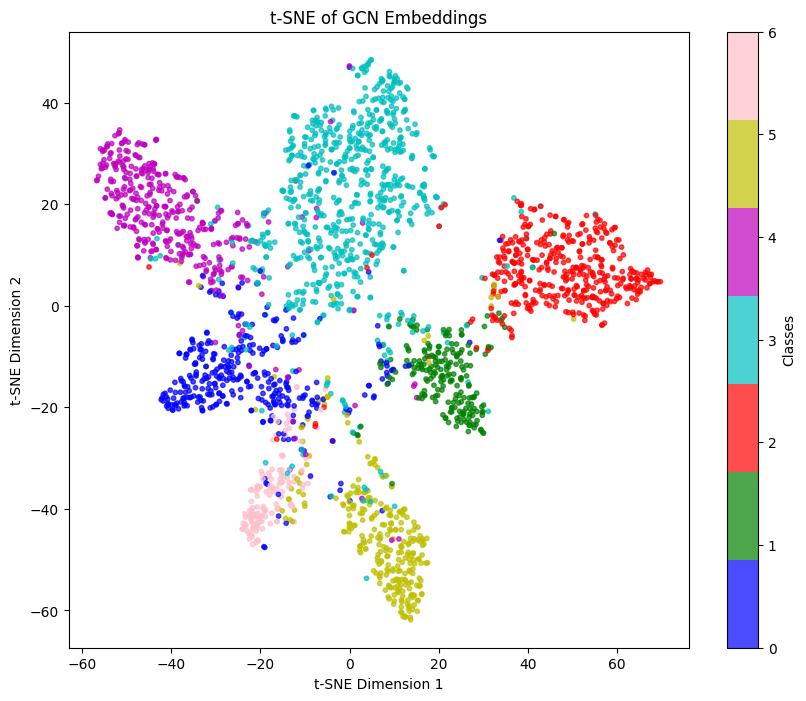

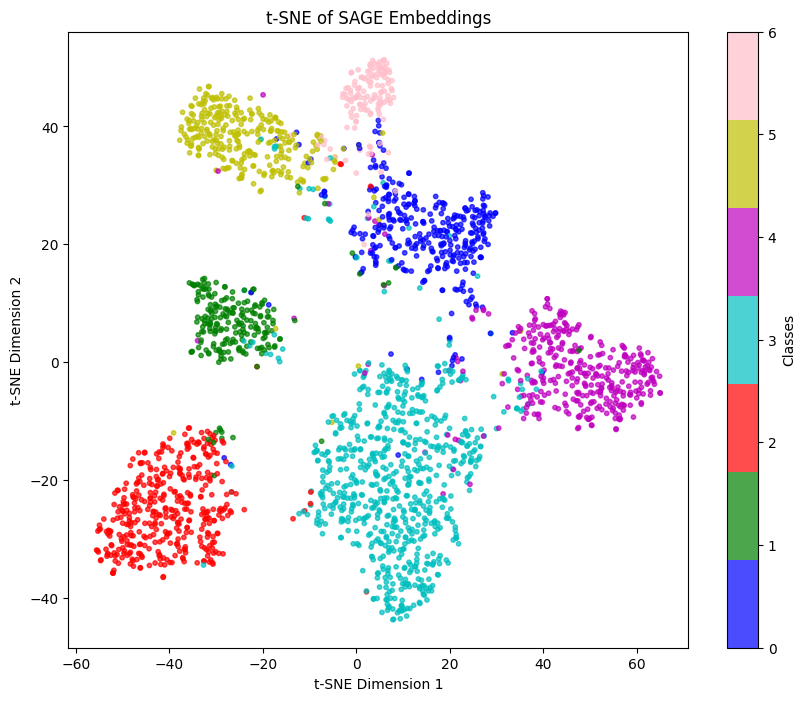

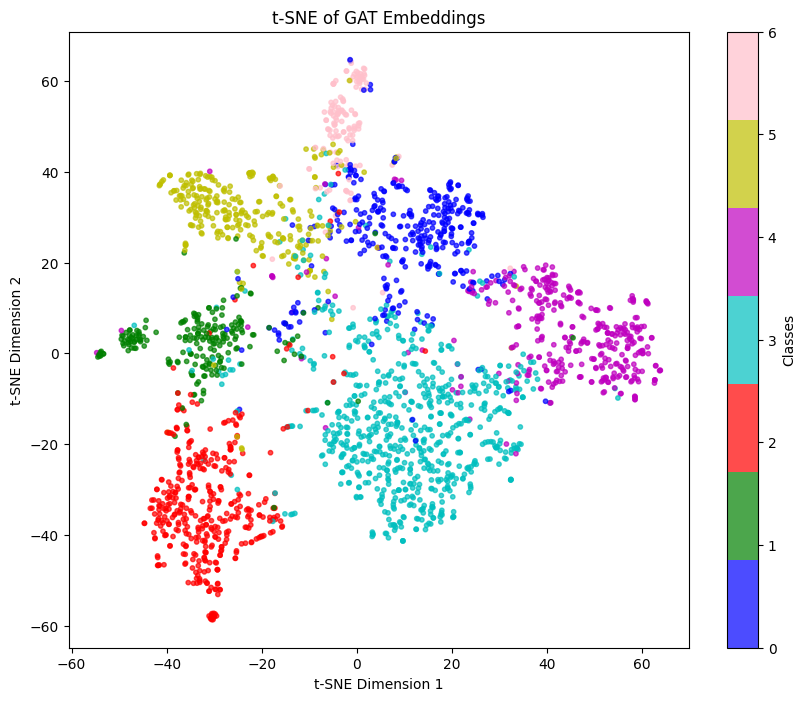

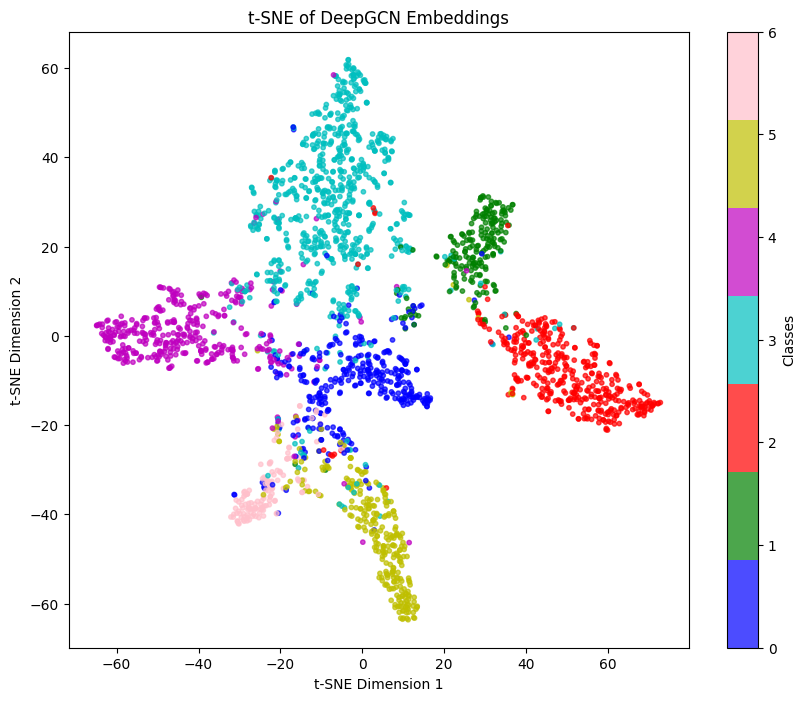

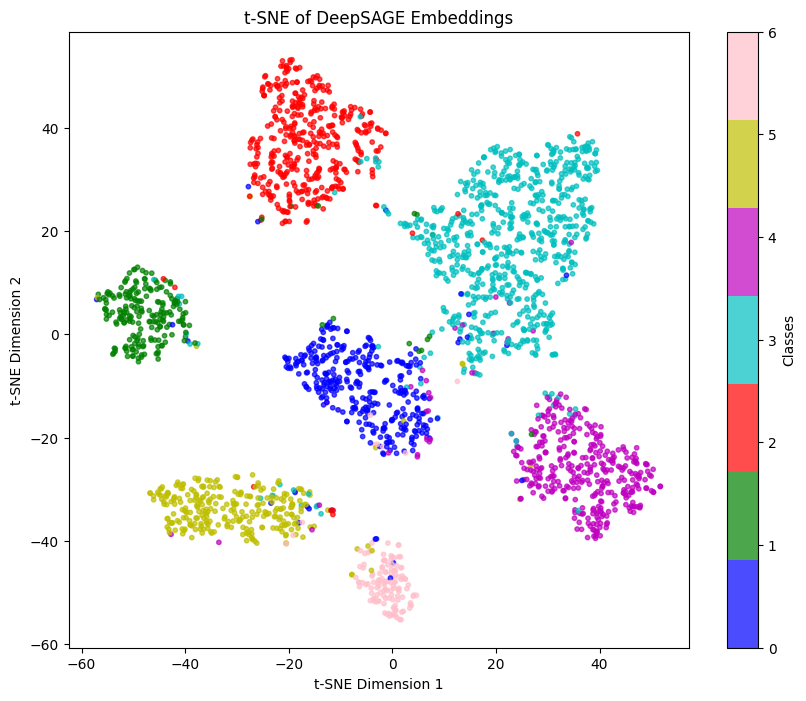

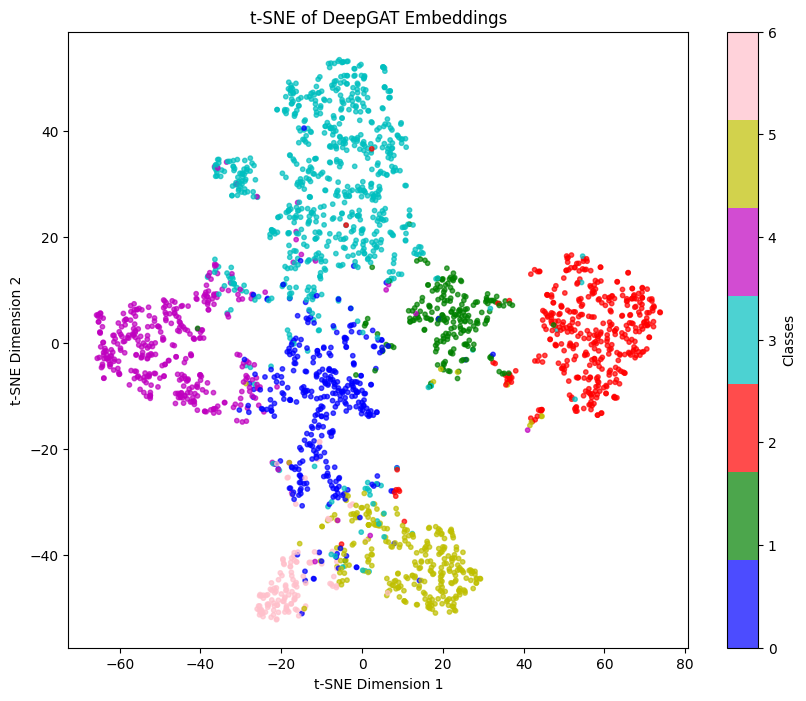

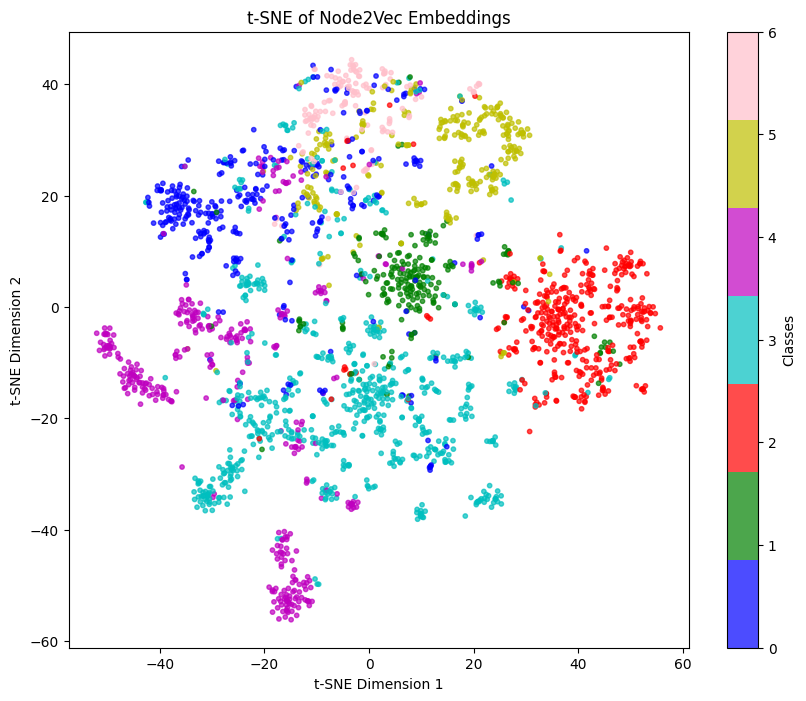

In [ ]:
# visualize 2d embeddings using scatter plot
def visualizeEmbeddings(embeddings, labels, mode, model_name):
    # map the labels to the corresponding colors (no modulo needed if labels are in the range 0-6)
    color_map = [colors[label % len(colors)] for label in labels]

    # create a custom colormap using the defined colors
    cmap = ListedColormap(colors)

    method = "PCA" if mode == "pca" else "t-SNE"
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(embeddings[:, 0], embeddings[:, 1], c=labels, cmap=cmap, s=10, alpha=0.7)
    plt.colorbar(scatter, label="Classes")
    plt.title(f"{method} of {model_name} Embeddings")
    plt.xlabel(f"{method} Dimension 1")
    plt.ylabel(f"{method} Dimension 2")
    model_path = os.path.join(task_path, f'{model_name}')
    plt.savefig(os.path.join(model_path, f'{method}.png'))
    plt.show()

# extract embeddings from the gnn model after the first convolutional layer
def getEmbeddings(model, data, task="NC"):
    model.eval()
    embeddings = None
    with torch.no_grad():
        if task == "NC":
            embeddings = model(data.x, data.edge_index, return_embeddings=True)
        elif task == "LP":
            embeddings = model.encode(data.x, data.edge_index)
    return embeddings

# reduce embeddings to 2d using pca and t-sne
def to2d(embeddings, mode="tsne"):
    if mode == "pca":
        pca = PCA(n_components=2, random_state=seed)
        embeddings_2d = pca.fit_transform(embeddings)
    elif mode == "tsne":
        tsne = TSNE(n_components=2, random_state=seed)
        embeddings_2d = tsne.fit_transform(embeddings)
    else:
        raise ValueError("Invalid mode. Choose 'pca' or 'tsne'.")
    return embeddings_2d

# set the mode for dimensionality reduction to tsne
mode = "tsne"

# visualize embeddings for each model
for model_name, model in best_models.items():
    embeddings = getEmbeddings(model, dataset).cpu().numpy()
    tsne_embeddings = to2d(embeddings, mode)
    visualizeEmbeddings(tsne_embeddings, dataset.y.cpu().numpy(), mode, model_name)

# node2vec comparison
node2vec_embeddings = nc.node2vec.get_embeddings().cpu().numpy()
node2vec_tsne = to2d(node2vec_embeddings, mode)
visualizeEmbeddings(node2vec_tsne, dataset.y.cpu().numpy(), mode, "Node2Vec")


<h2>Explainability</h2>

Here I selected some nodes for further analysis using the Graph Explainer.

In [ ]:
# function to visualize edge weights using GNNExplainer
def visualize_edge_weights_gnnexplainer(edge_mask, data, node_idx, preds, threshold=0.0, seed=seed):
    # get labels and edge_index from the data
    labels = data.y
    edge_index = data.edge_index

    # create a new graph
    G = nx.Graph()

    # iterate over edge_index to add edges with mask > threshold
    for i, edge in enumerate(edge_index.T):
        if edge_mask[i] > threshold:
            G.add_edge(edge[0].item(), edge[1].item(), weight=edge_mask[i])
            G.add_node(edge[0].item(), pred=preds[edge[0].item()])
            G.add_node(edge[1].item(), pred=preds[edge[1].item()])

    # get edges and normalize the weights
    edges = G.edges(data=True)
    original_weights = [edge[2]['weight'].item() for edge in edges]
    min_val = min(original_weights)
    max_val = max(original_weights)
    normalized_weights = [(x - min_val) / (max_val - min_val) for x in original_weights]

    # get node colors based on the prediction
    node_colors = [int(G.nodes[n]['pred']) for n in G.nodes]

    # create positions for the nodes using spring layout
    pos = nx.spring_layout(G, seed=seed)

    # draw the graph with the computed edge weights and node colors
    nx.draw(
        G, pos,
        with_labels=True,
        node_size=700,
        node_color=node_colors,
        cmap=plt.get_cmap('rainbow'),
        font_size=10,
        font_weight='bold',
        edge_color=normalized_weights,
        edge_cmap=plt.cm.Blues,
        alpha=0.8
    )

    # prepare edge labels for displaying the weight values
    edge_labels = {
        (u, v): f'{w:.3f}' for ((u, v, d), w) in zip(edges, normalized_weights)
    }

    # draw the edge labels on the graph
    nx.draw_networkx_edge_labels(
        G, pos,
        edge_labels=edge_labels,
        font_color='black'
    )

    # title the plot with the node's true label and prediction
    plt.title(f'GNNExplainer on node {node_idx}: label = {labels[node_idx]}, pred = {preds[node_idx]}')
    plt.show()


I gathered nodes based on different criteria and reduced the number to 10 when too many nodes were selcted.

In [ ]:
# define a function to select nodes based on various criteria
def select_nodes_for_explanation(data, preds, probs):
    # select labels from the data object
    labels = data.y
    selected_nodes = {}

    # 1. correctly predicted nodes with uncertainty (low confidence)
    correct_nodes = (preds == labels).nonzero(as_tuple=True)[0]
    correct_probs = probs[correct_nodes]
    # select nodes where the max probability is uncertain (close to 0.5 for multi-class classification)
    uncertain_correct_nodes = correct_nodes[correct_probs.max(dim=1).values < 0.25]
    selected_nodes['Uncertain Correct'] = uncertain_correct_nodes.tolist()[:10]

    # 2. misclassified nodes with high confidence (certain wrong predictions)
    misclassified_nodes = (preds != labels).nonzero(as_tuple=True)[0]
    misclassified_probs = probs[misclassified_nodes]
    # select misclassified nodes where the model is confident in the wrong prediction
    certain_wrong_nodes = misclassified_nodes[misclassified_probs.max(dim=1).values > 0.35]
    selected_nodes['Certain Wrong'] = certain_wrong_nodes.tolist()

    # 3. high degree nodes
    degree_values = degree(data.edge_index[0], num_nodes=data.num_nodes)
    # select nodes with high degree
    high_degree_nodes = torch.where(degree_values > degree_values.max() - 135)[0]
    selected_nodes['High Degree'] = high_degree_nodes.tolist()

    # 4. low degree nodes (degree < 2 for this example)
    low_degree_nodes = degree_values < 2
    selected_nodes['Low Degree'] = low_degree_nodes.nonzero(as_tuple=True)[0].tolist()[:10]

    # 5. influential nodes (based on betweenness centrality)
    graph = to_networkx(data)  # convert to networkx graph from pyg data
    centrality = nx.betweenness_centrality(graph)
    # sort nodes by centrality and select top 10 influential nodes
    sorted_nodes_by_centrality = sorted(centrality, key=centrality.get, reverse=True)
    influential_nodes = sorted_nodes_by_centrality[:10]
    selected_nodes['Influential'] = influential_nodes

    return selected_nodes


Experiment with Uncertain Correct


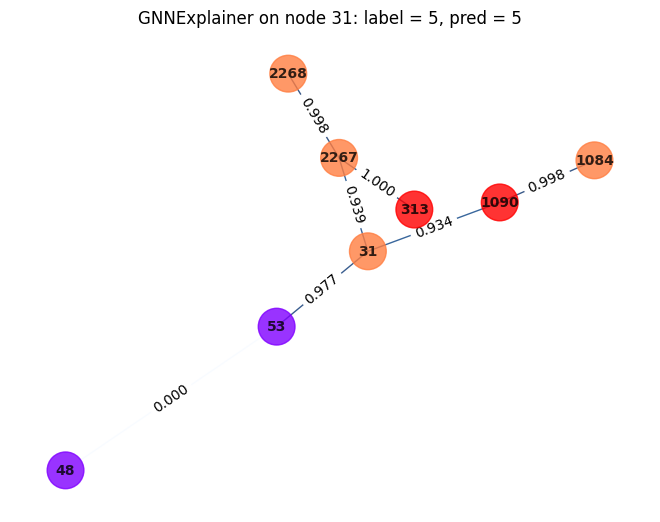

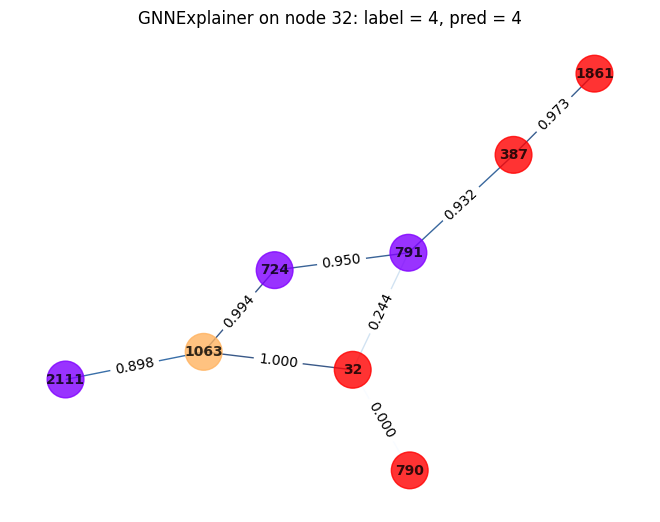

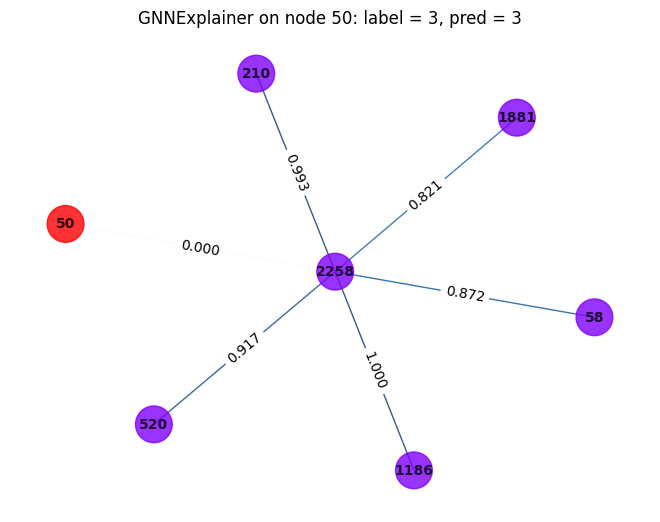

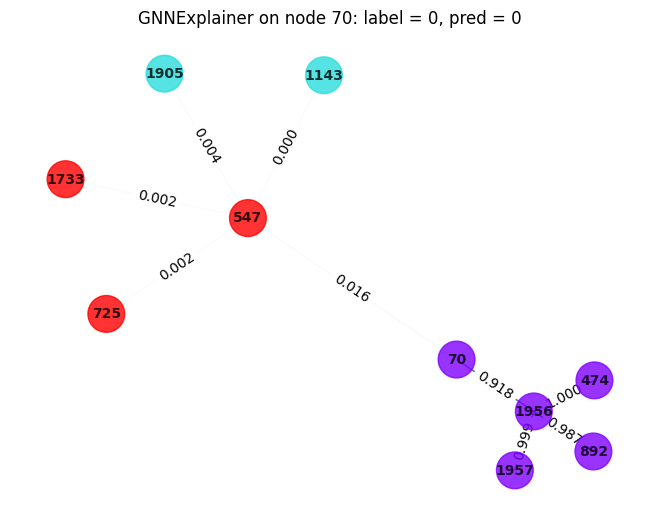

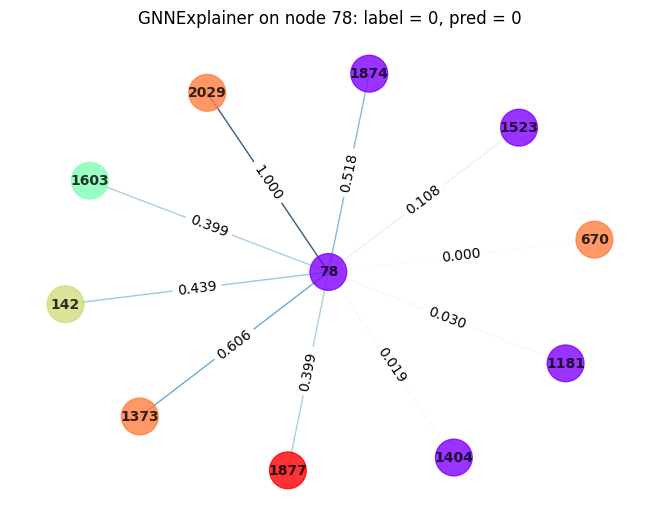

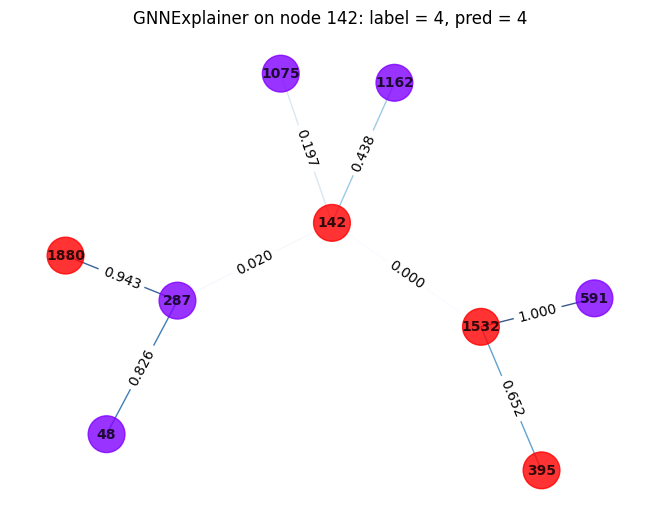

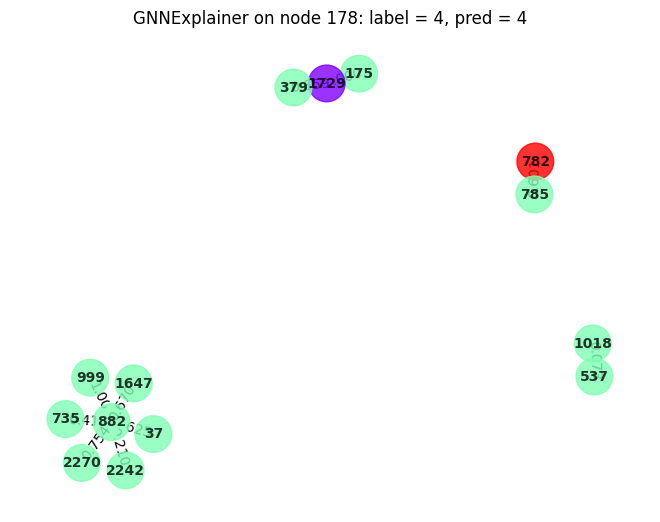

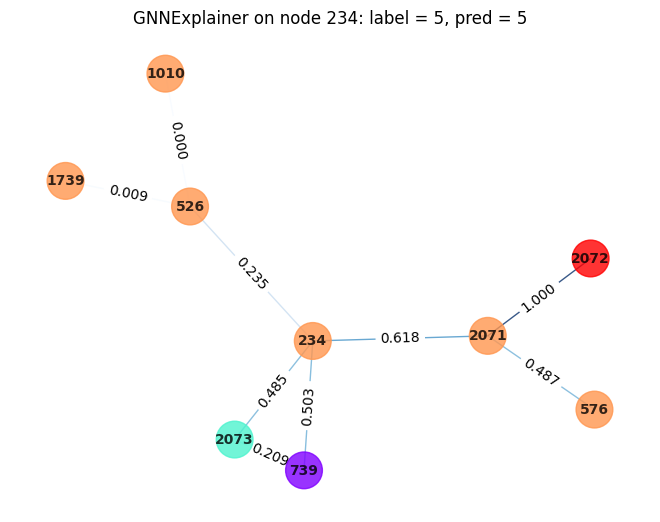

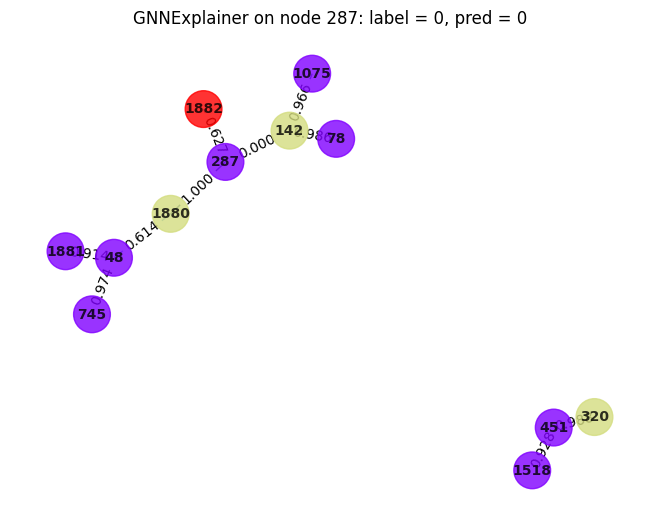

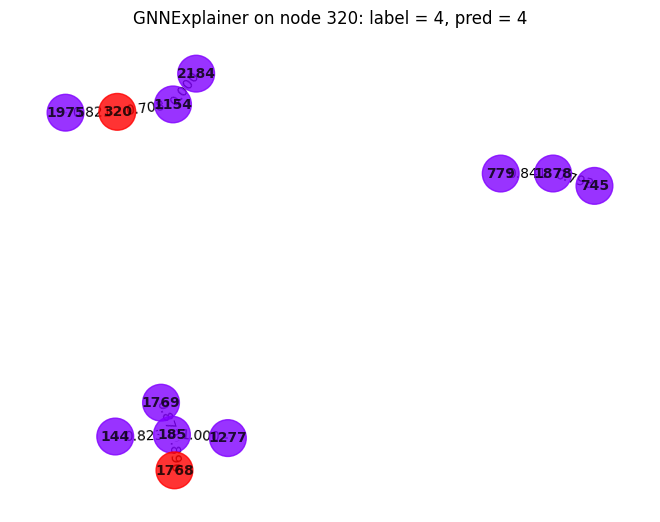

Experiment with Certain Wrong


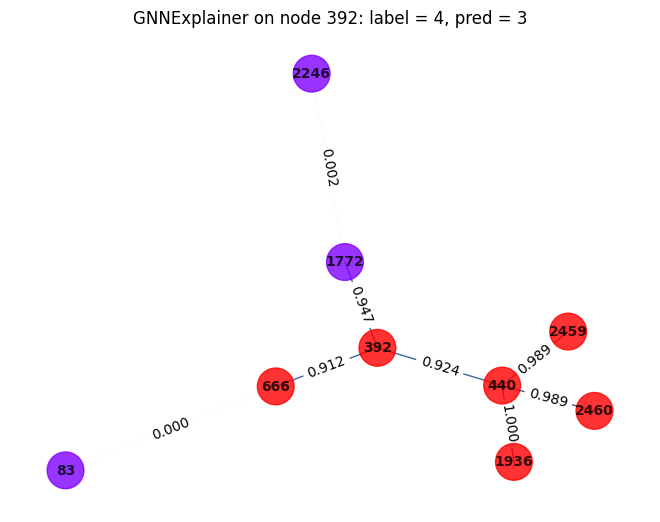

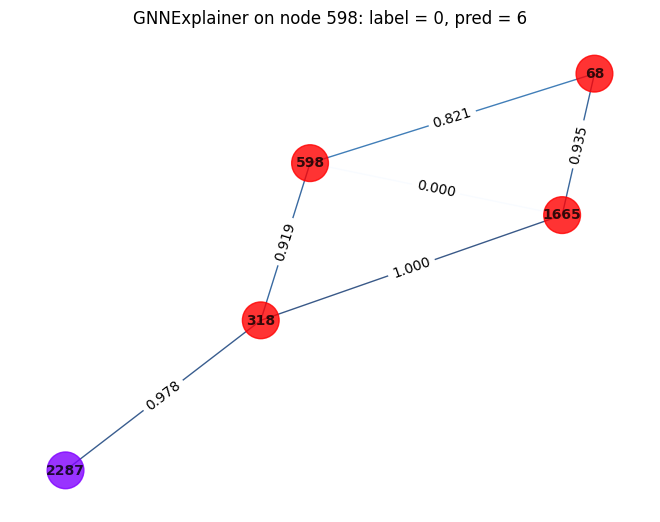

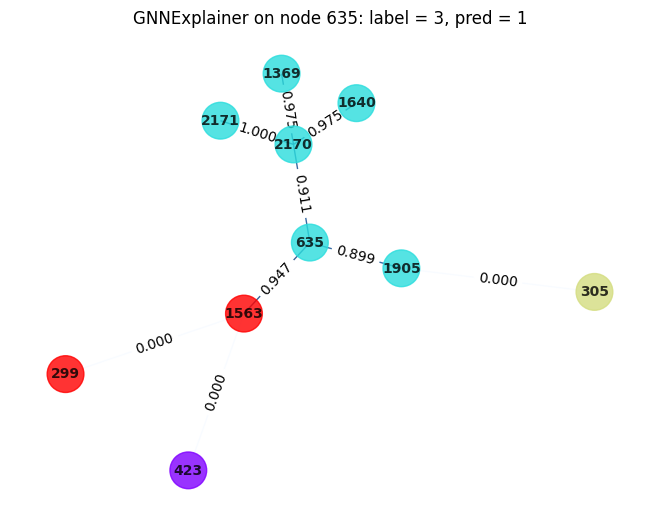

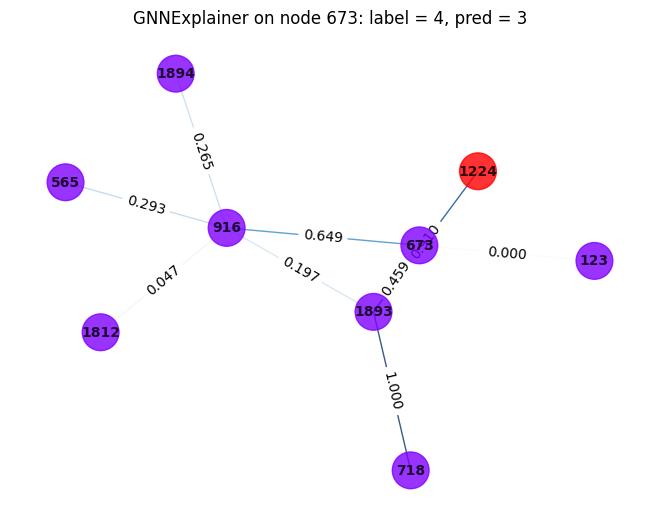

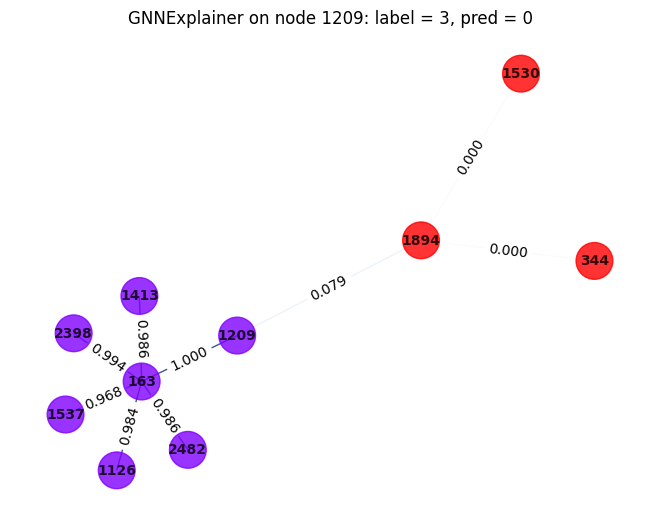

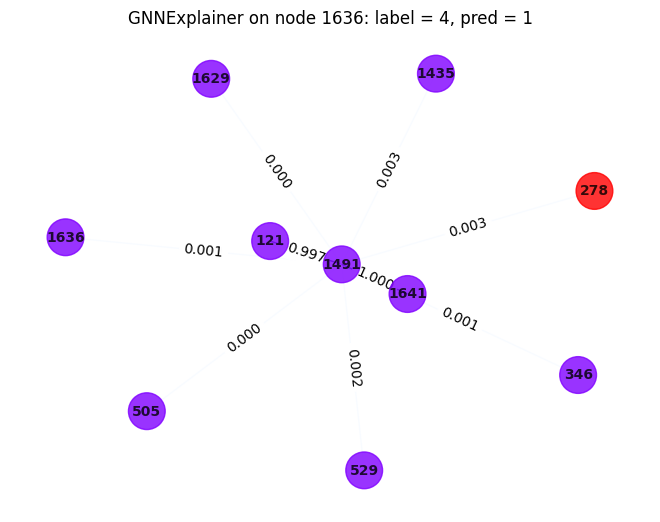

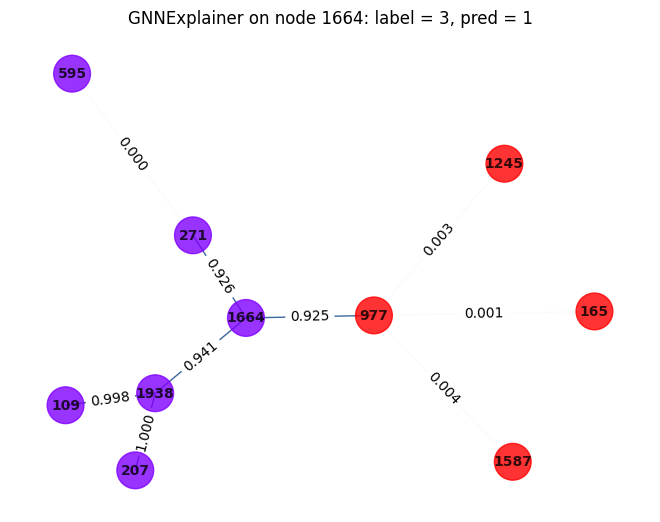

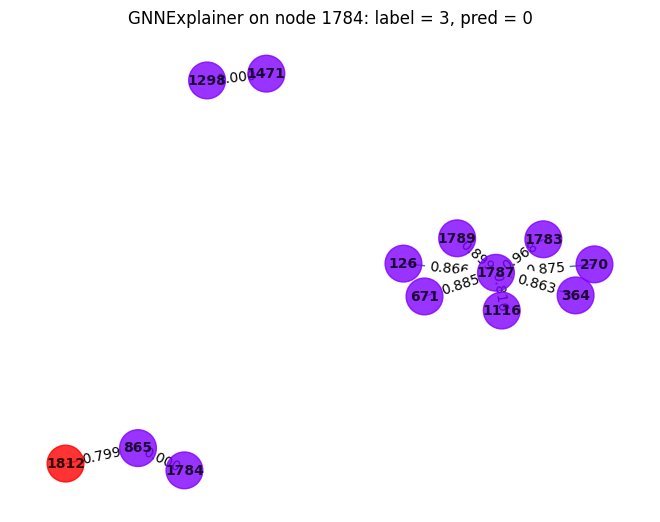

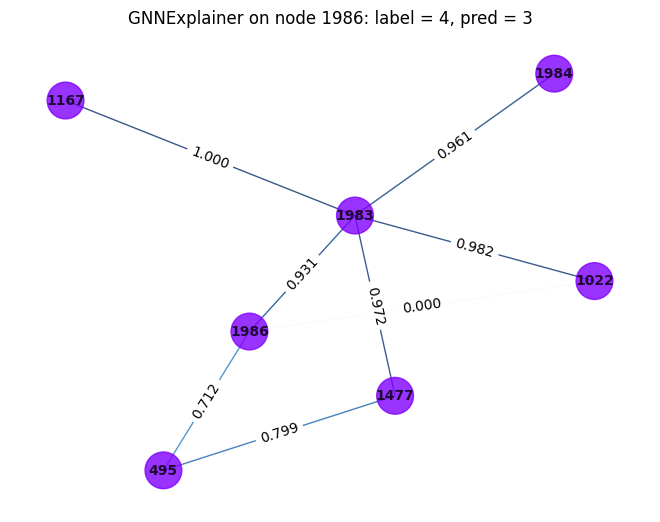

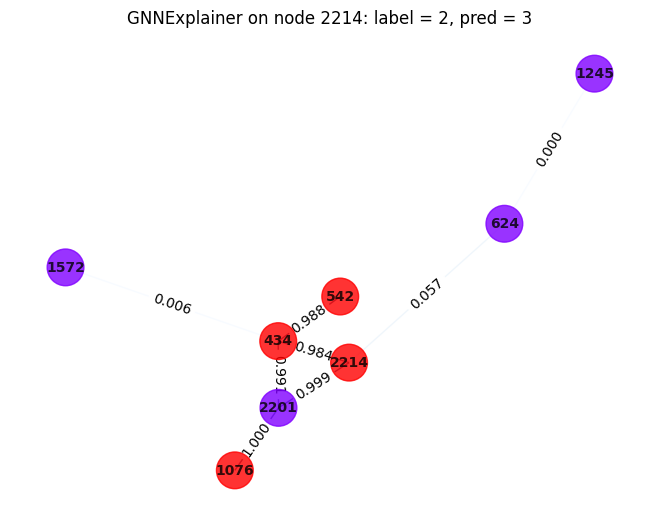

Experiment with High Degree


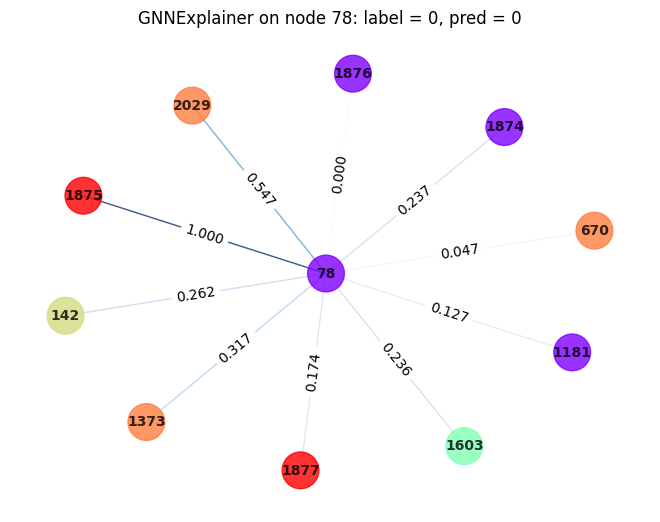

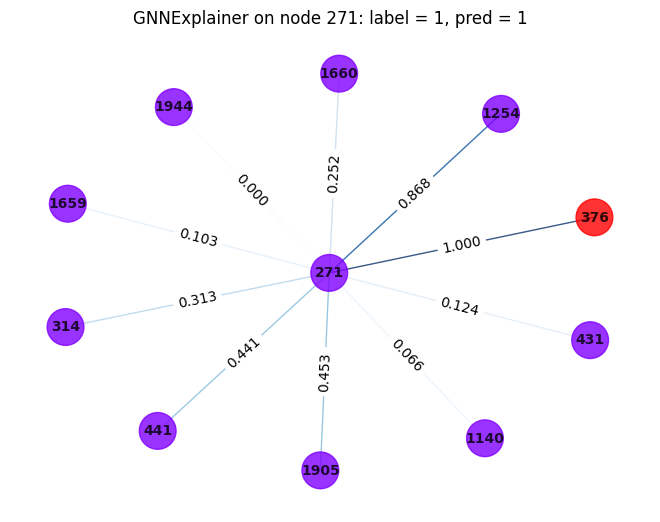

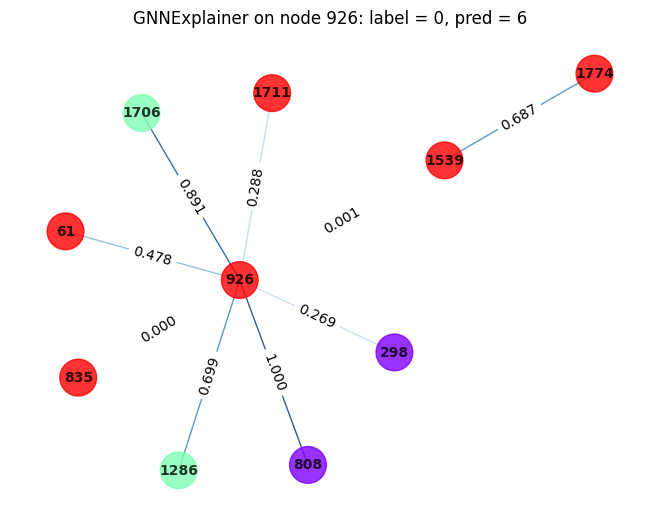

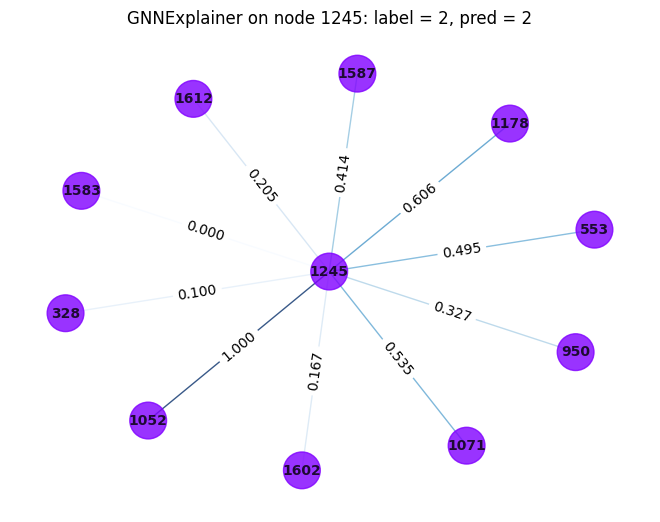

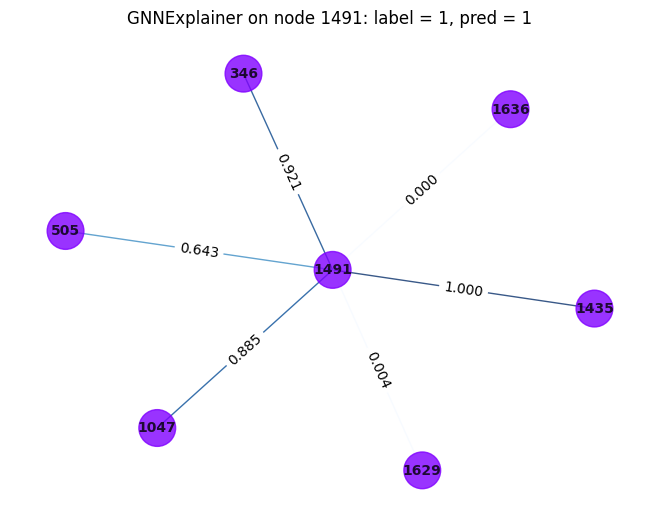

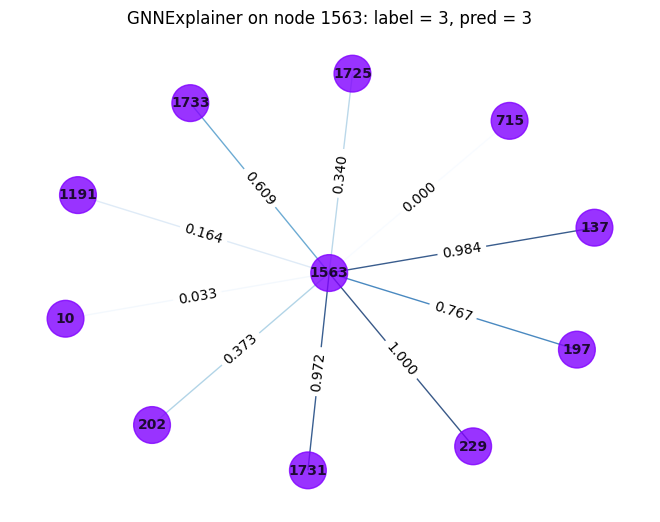

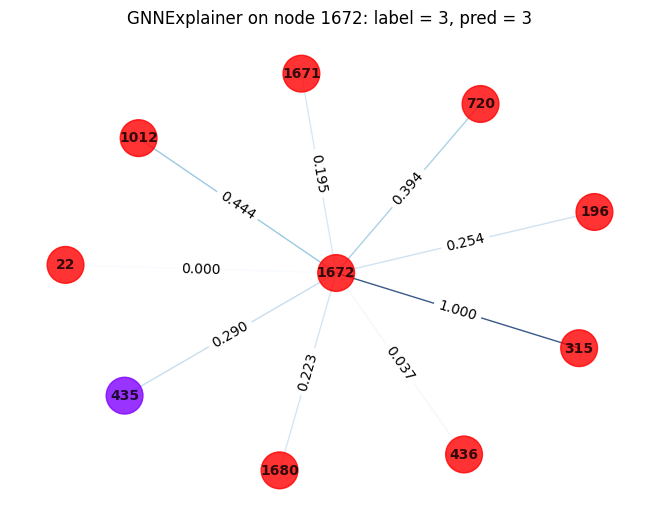

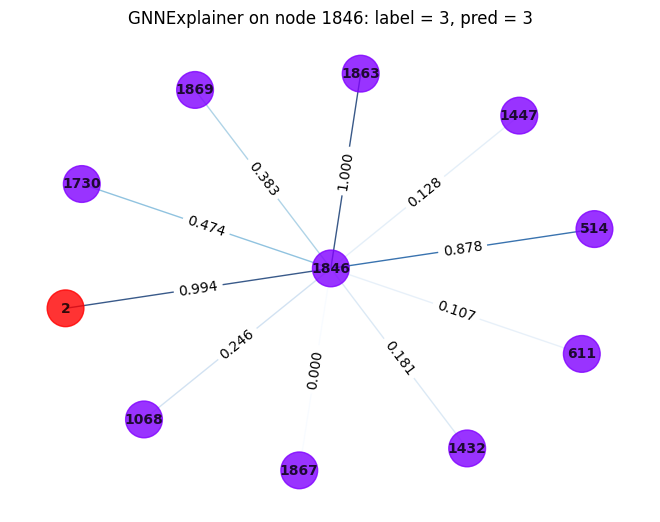

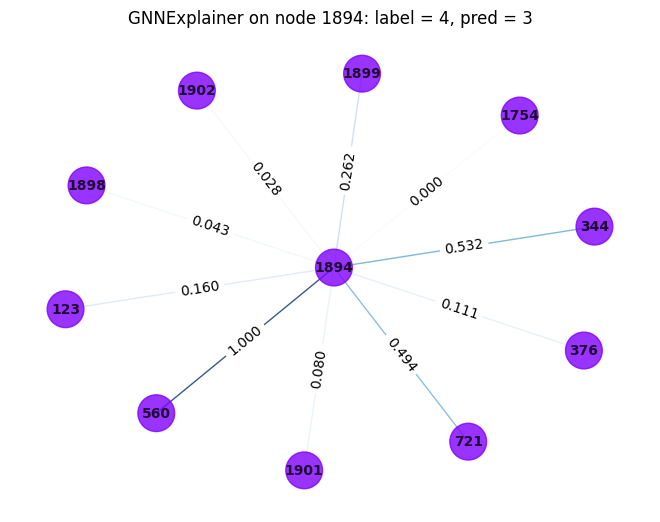

Experiment with Low Degree


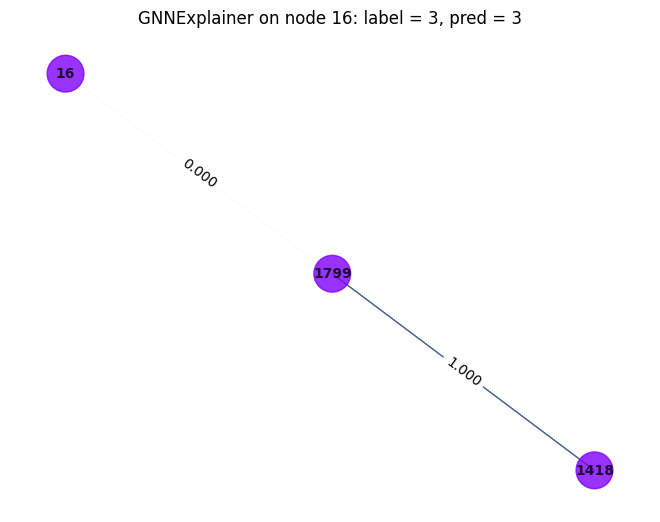

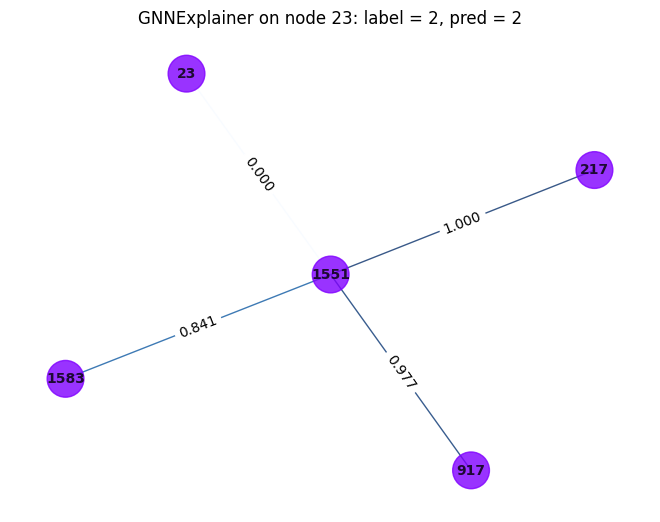

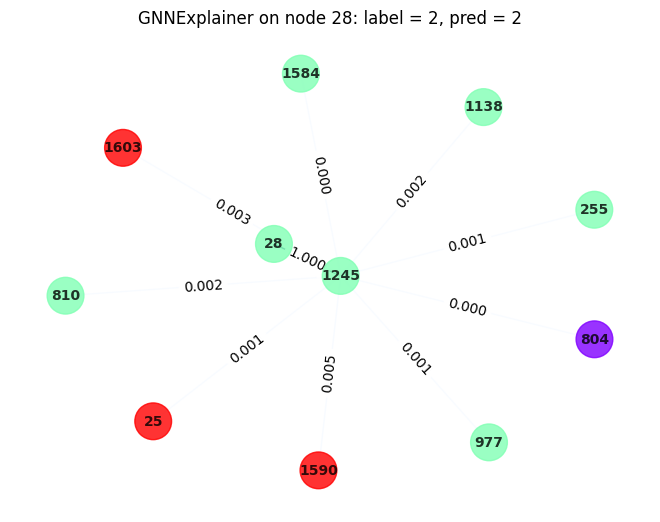

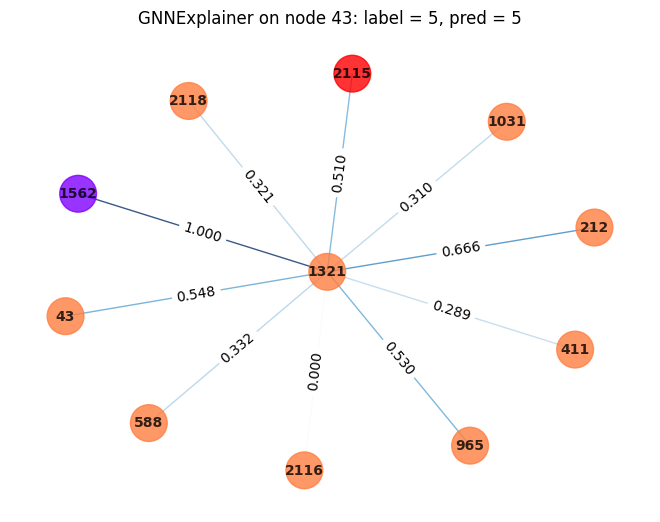

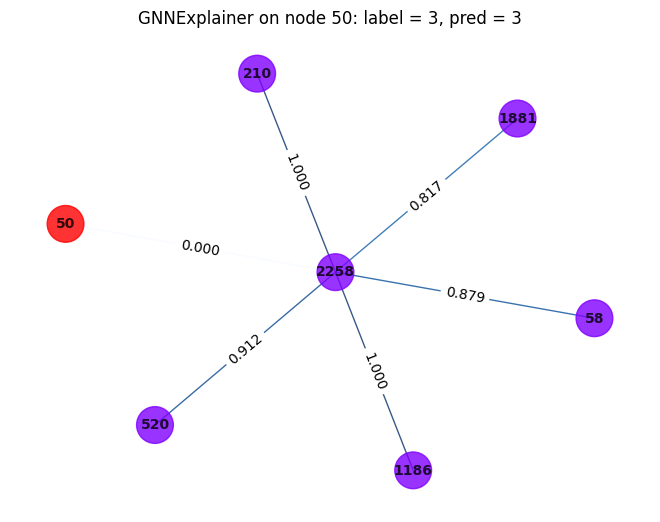

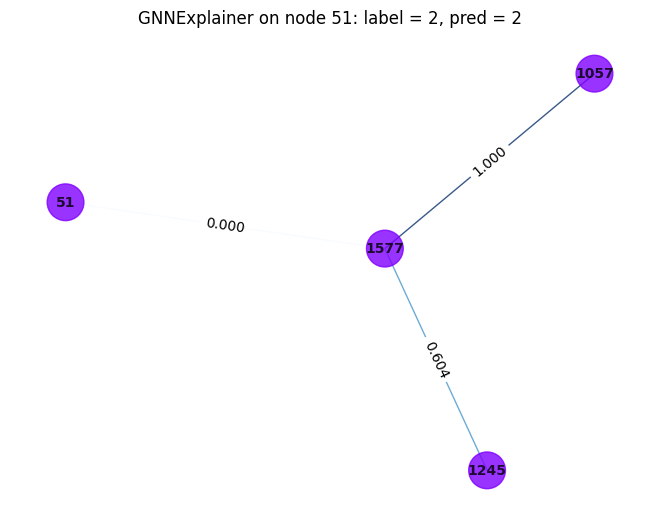

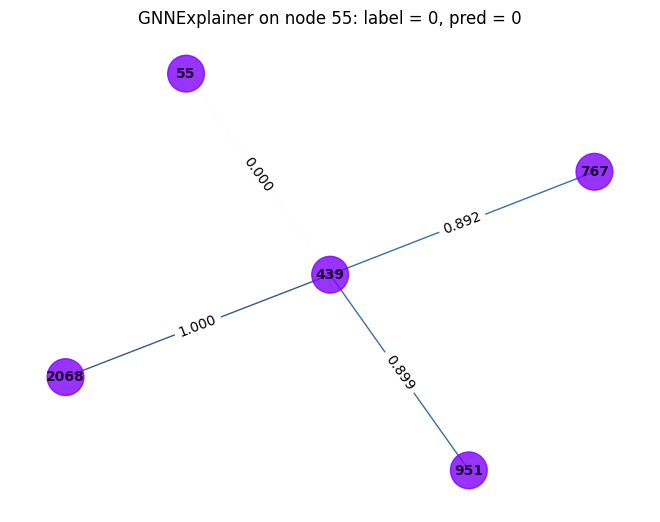

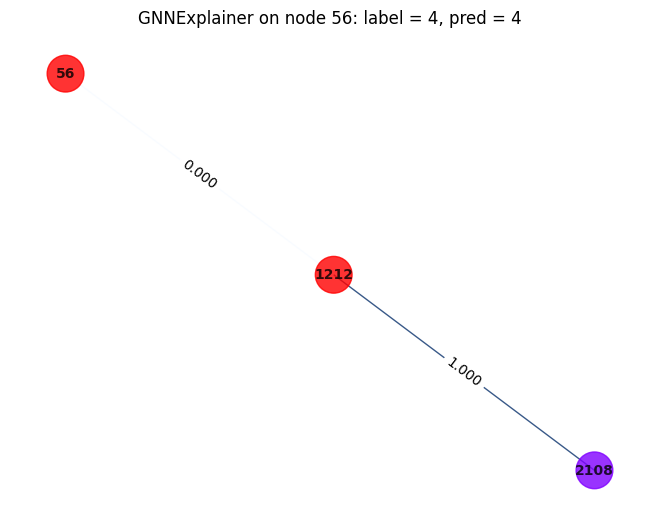

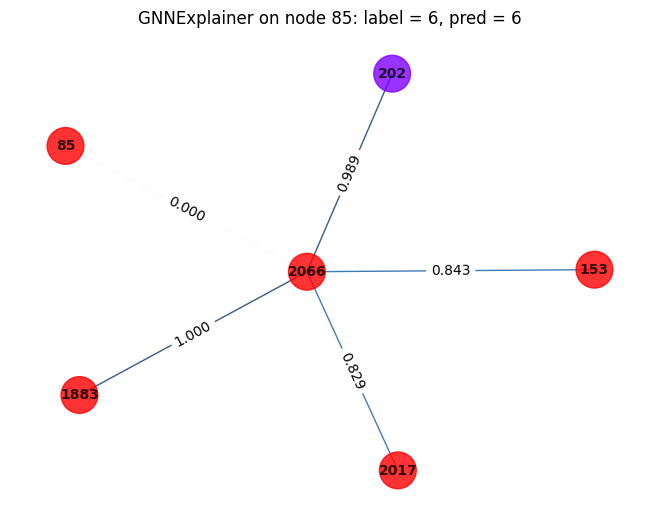

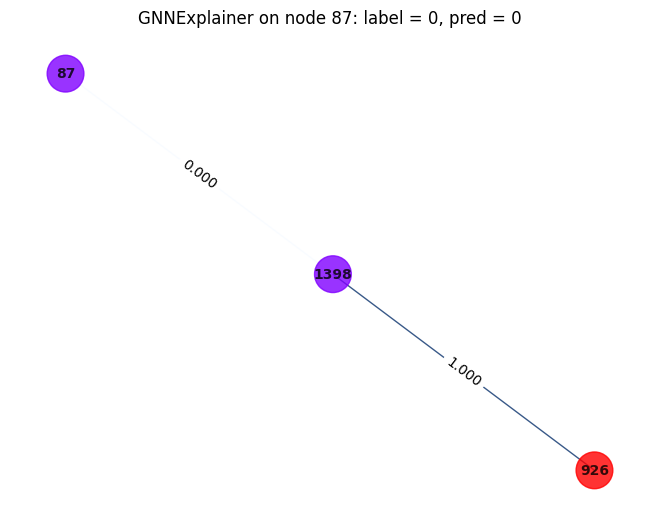

Experiment with Influential


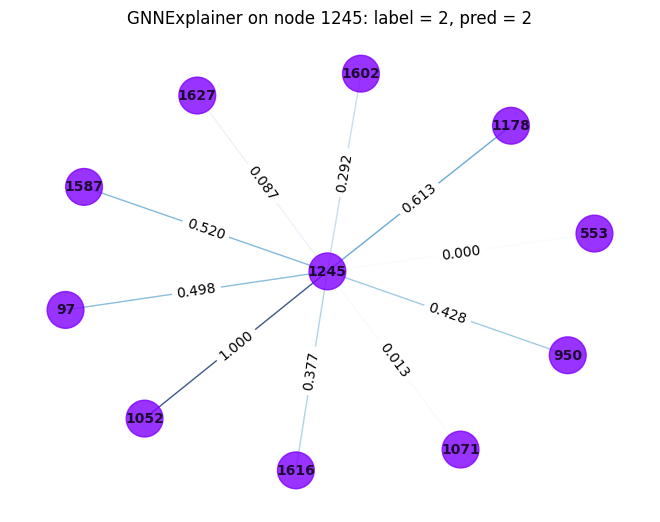

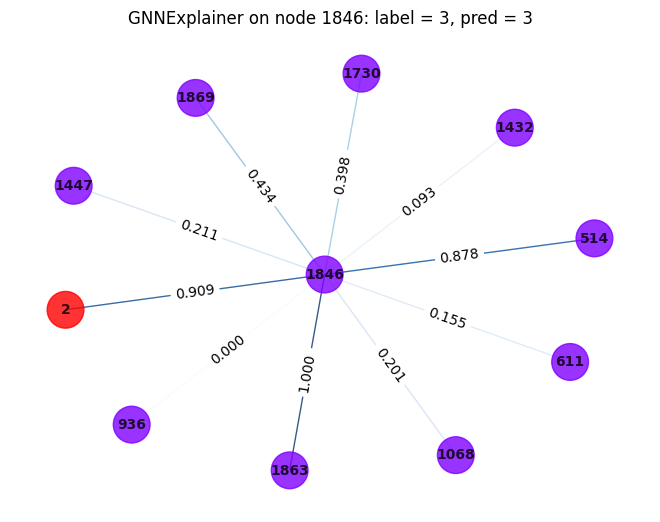

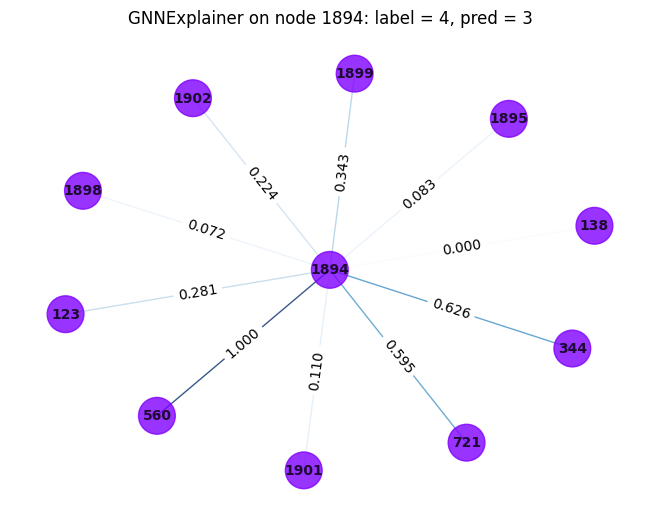

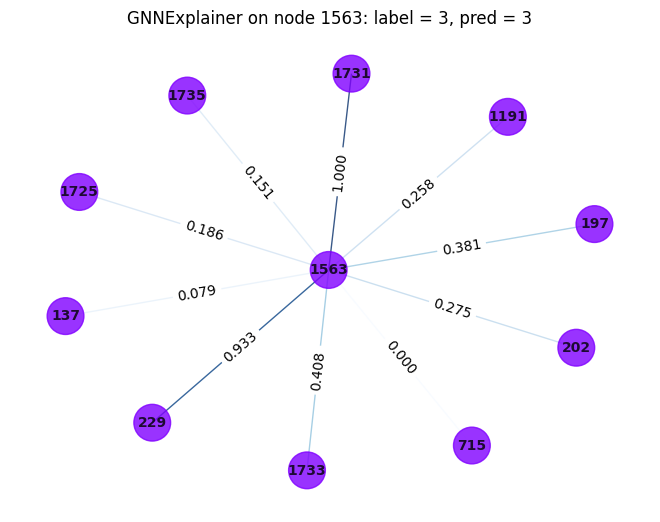

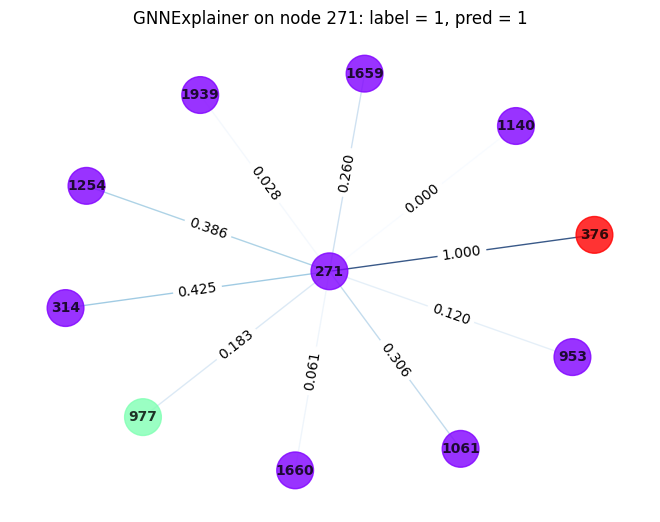

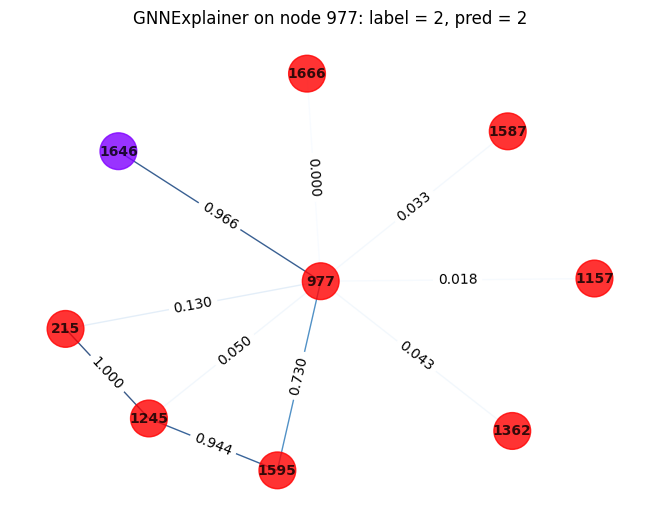

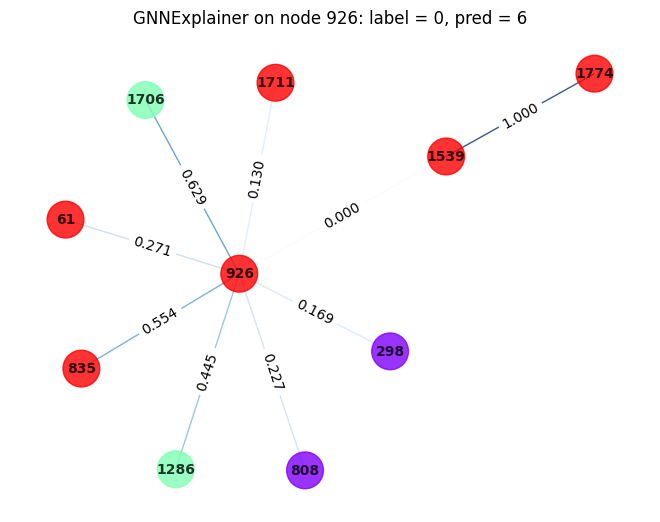

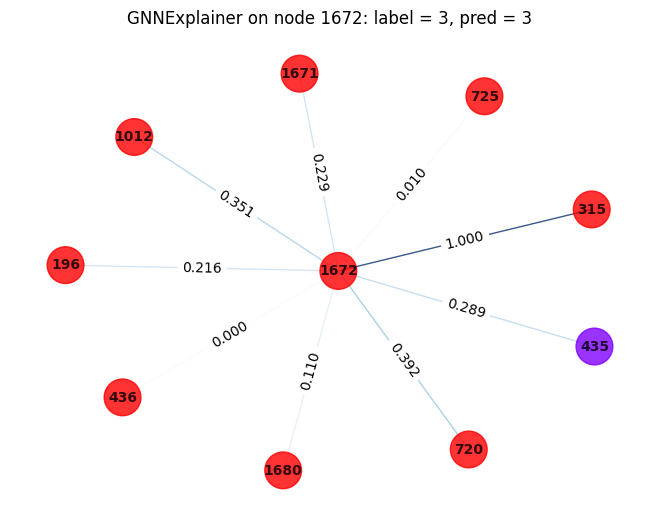

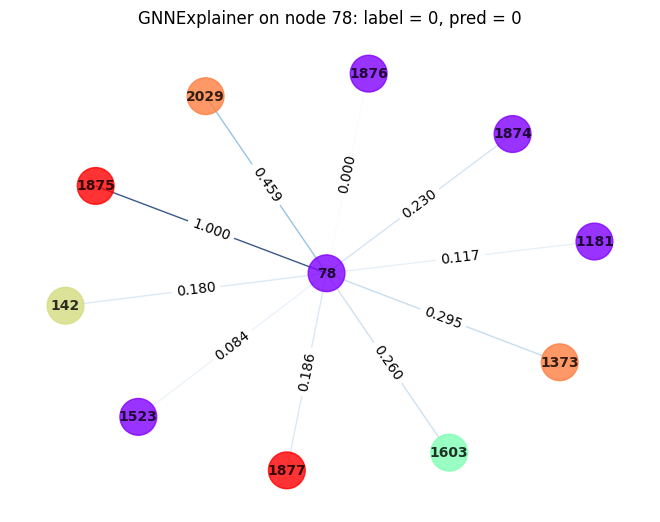

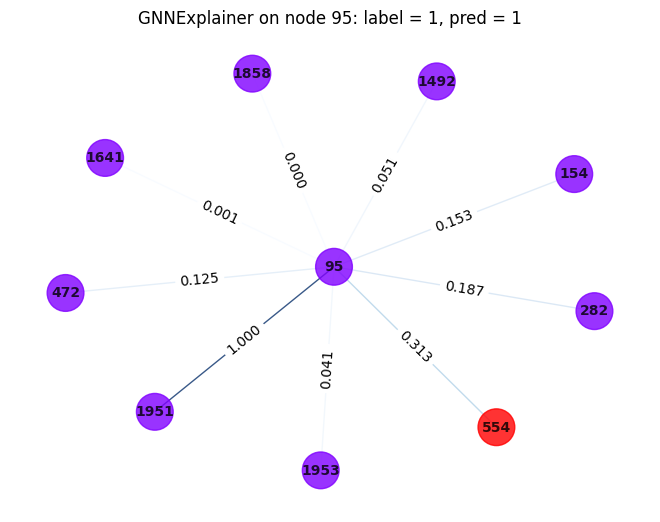

In [ ]:
# define max number of neighbors for explanation
max_neighbors = 10

# get the model for SAGE
model = best_models["SAGE"]
data = dataset[0]

# initialize the explainer with specified configurations
explainer = Explainer(
  model=model,  # the model to explain
  algorithm=GNNExplainer(epochs=200),  # use GNNExplainer for 200 epochs
  explanation_type='model',  # type of explanation (model-level)
  node_mask_type=None,  # node masking not used
  edge_mask_type='object',  # mask for edge-level explanations
  model_config=dict(
      mode='multiclass_classification',  # classification mode
      task_level='node',  # explanation level (node-level)
      return_type='log_probs',  # return log probabilities
  ),
  threshold_config = dict(
        threshold_type ='topk',  # use top-k thresholding
        value=max_neighbors,  # apply threshold with the top k neighbors
  ),
)

model.eval()
probs = torch.exp(model(data.x, data.edge_index))
_, preds = probs.max(dim=1)
selected_nodes = select_nodes_for_explanation(data, preds, probs)

for k, v in selected_nodes.items():
    print(f"Experiment with {k}")
    # call the function for each selected node
    for node_idx in v:
      # visualize_explanation_for_node(explainer, threshold=0.0, node_idx=node_idx)
      explanation = explainer(data.x.to(device), data.edge_index.to(device), index=node_idx)
      edge_mask   = explanation.edge_mask
      visualize_edge_weights_gnnexplainer(edge_mask, data, node_idx, preds)

<h2>Link Prediction </h2>

Here I implemented the code for performing link prediction on the Cora dataset.

In [ ]:
# set the task to "LP" (Link Prediction)
task = "LP"
task_path = os.path.join(dir_path, task)  # define the task path

# create task directory if it does not exist
if not os.path.exists(task_path):
    os.makedirs(task_path)


I splitted edges into train, validation and test sets.

In [ ]:
# initialize the RandomLinkSplit for link prediction task
split = RandomLinkSplit(
    num_val=0.1,  # 10% of the data for validation
    num_test=0.1,  # 10% of the data for testing
    is_undirected=True,  # undirected graph
    add_negative_train_samples=False,  # no negative sampling in training data
    neg_sampling_ratio=1.0,  # ratio of negative samples for validation and test
)

# perform the split on the dataset
train_edges, val_edges, test_edges = split(dataset[0])


In [ ]:
# get the edge index from the original graph (dataset)
original_edges = dataset[0].edge_index

# convert to a set of tuples for faster lookup (undirected, so we store both (u, v) and (v, u))
original_edge_set = set(map(tuple, original_edges.t().cpu().numpy()))
original_edge_set.update(map(tuple, original_edges.flip(0).t().cpu().numpy()))  # add reverse edges

# function to count the number of positive edges in a split
def count_positive_edges(split_edges, original_edge_set):
    # convert edge_index to tuples
    split_edge_list = list(map(tuple, split_edges.t().cpu().numpy()))
    # check existence of (u, v) or (v, u) in the original edge set
    positive_edges = [edge for edge in split_edge_list if edge in original_edge_set]
    return len(positive_edges)

# count positive edges for each split
train_positive_edges = count_positive_edges(train_edges.edge_label_index, original_edge_set)
val_positive_edges = count_positive_edges(val_edges.edge_label_index, original_edge_set)
test_positive_edges = count_positive_edges(test_edges.edge_label_index, original_edge_set)

# total edges in each set
train_edges_count = train_edges.edge_label_index.shape[1]
val_edges_count = val_edges.edge_label_index.shape[1]
test_edges_count = test_edges.edge_label_index.shape[1]

# compute the proportions of positive edges in each set
train_positive_proportion = train_positive_edges / train_edges_count
val_positive_proportion = val_positive_edges / val_edges_count
test_positive_proportion = test_positive_edges / test_edges_count

# print the proportions
print(f"proportion of positive edges in train set: {train_positive_proportion:.4f}")
print(f"proportion of positive edges in validation set: {val_positive_proportion:.4f}")
print(f"proportion of positive edges in test set: {test_positive_proportion:.4f}")


proportion of positive edges in train set: 1.0000
proportion of positive edges in validation set: 0.5000
proportion of positive edges in test set: 0.5000


I defined the models for link prediction, using again the GNNModule defined above.

In [ ]:
class LinkPredictor(torch.nn.Module):
    def __init__(self, model_name, input_dim, hidden_dim, output_dim, num_layers, dropout_rate=0.5, heads=8, concat=True, mode="dp"):
        super(LinkPredictor, self).__init__()
        # select the convolution module based on the model name
        convolution = convolution_module(model_name)
        # initialize the embedding using the GNN module
        self.embedding = GNNModule(convolution, input_dim, hidden_dim, num_layers, dropout_rate, heads, concat)
        self.mode = mode

        if model_name == "GAT":
            hidden_input = hidden_dim * heads if concat else hidden_dim
            self.last_conv = convolution(hidden_input, output_dim, heads=1, concat=False, dropout=dropout_rate)
            self.dropout = Identity()  # no dropout for GATConv output
        else:
            self.last_conv = convolution(hidden_dim, output_dim)
            self.dropout = Dropout(dropout_rate) if dropout_rate > 0 else Identity()

        if mode == "dp":
            pass
        elif mode == "mlp":
            # mlp-based decoder
            self.mlp = Linear(output_dim, 1)  # output a single score

        else:
            raise ValueError("invalid mode. choose 'dp' or 'mlp'.")
        # apply sigmoid function for final output
        self.sigmoid = Sigmoid()

    def encode(self, x, edge_index):
        # pass data through the embedding module (GNN)
        x = self.embedding(x, edge_index)
        z = self.dropout(self.last_conv(x, edge_index))
        return z

    def decode(self, z, edge_label_index):
        # extract source and target node indices
        source_embeddings = z[edge_label_index[0]]
        target_embeddings = z[edge_label_index[1]]

        if self.mode == "dp":
            # dot product for the prediction
            dot_product = torch.sum(source_embeddings * target_embeddings, dim=1)
            return self.sigmoid(dot_product)

        elif self.mode == "mlp":
            # multiply the source and target embeddings
            concatenated = source_embeddings * target_embeddings
            # apply the sigmoid activation to get probabilities
            return self.sigmoid(self.mlp(concatenated))


In [ ]:
# define a dictionary to store edges for train, validation, and test sets
edges = {
    "train": train_edges.to(device),
    "val": val_edges.to(device),
    "test": test_edges.to(device)
}

edges

{'train': Data(x=[2485, 1433], edge_index=[2, 8114], y=[2485], train_mask=[2485], val_mask=[2485], test_mask=[2485], edge_label=[4057], edge_label_index=[2, 4057]),
 'val': Data(x=[2485, 1433], edge_index=[2, 8114], y=[2485], train_mask=[2485], val_mask=[2485], test_mask=[2485], edge_label=[1012], edge_label_index=[2, 1012]),
 'test': Data(x=[2485, 1433], edge_index=[2, 9126], y=[2485], train_mask=[2485], val_mask=[2485], test_mask=[2485], edge_label=[1012], edge_label_index=[2, 1012])}

The Trainer class helps training and testing the models.

In [ ]:
class TrainerLinkPrediction:
    def __init__(self, model, optimizer, criterion, edges):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.edges = edges

        # initialize metrics for the training dataset
        self.metrics = {
            "accuracy": Accuracy(task="binary").to(device),
            "precision": Precision(task="binary", average='weighted').to(device),
            "recall": Recall(task="binary", average='weighted').to(device),
            "f1": F1Score(task="binary", average='weighted').to(device),
            "auc": AUROC(task="binary").to(device),
        }

    def fit(self, epochs=200, plot=False):
        # train the model on the training dataset
        train_edges = self.edges["train"]

        self.model.train()
        metrics_history = defaultdict(list) if plot else None

        for epoch in range(epochs):
            self.optimizer.zero_grad()
            # encode and compute embeddings
            z = self.model.encode(train_edges.x, train_edges.edge_index)

            # sampling training negatives for every training epoch
            neg_edge_index = negative_sampling(
                edge_index=train_edges.edge_index,
                num_nodes=train_edges.num_nodes,
                num_neg_samples=train_edges.edge_label_index.size(1),
            )
            # concatenate positive and negative edges
            edge_label_index = torch.cat([train_edges.edge_label_index, neg_edge_index], dim=-1)
            # create labels for both positive and negative edges
            edge_label = torch.cat([
                train_edges.edge_label,
                train_edges.edge_label.new_zeros(neg_edge_index.size(1))
            ], dim=0)

            # forward pass
            out = self.model.decode(z, edge_label_index).squeeze()  # make predictions
            loss = self.criterion(out, edge_label)  # compute loss
            loss.backward()  # backpropagate the gradients
            self.optimizer.step()  # update model parameters

            if plot:
                metrics_history["loss"].append(loss.item())  # record loss
                metrics = self.test(self.edges["test"])  # test the model on the test edges
                for key, value in metrics.items():
                    metrics_history[key].append(value)
                self.model.train()  # reset model to train mode after evaluation

        if plot:
            return metrics_history

    def validate(self):
        # validate the model on the validation set of the training dataset
        return self.test(self.edges["val"])

    def test(self, edges=None):
        # test the model on the given dataset, using initialized metrics
        edges = edges if edges is not None else self.edges["test"]  # use the test set if no other set is given

        self.model.eval()
        results = {}
        with torch.no_grad():
            z = self.model.encode(edges.x, edges.edge_index)  # encode node features and edge indices
            out = self.model.decode(z, edges.edge_label_index).squeeze()  # make predictions

            # convert probabilities to binary predictions (0 or 1)
            pred = (out > 0.5).float()

            # update metrics
            results = {}
            for name, metric in self.metrics.items():
                if name == "auc":
                    metric.update(out, edges.edge_label)  # use probabilities for AUROC
                else:
                    metric.update(pred, edges.edge_label)  # use binary predictions for others
                results[name] = metric.compute().item()
                metric.reset()

        return results


I used grid search to identify the best hyperparameters for my models.

In [ ]:
models = []  # list to hold models
best_params = {}  # dictionary to store best parameters for each model

for model in models:
    # define hyperparameter search space
    num_layers = [3, 5, 10] if model.startswith("Deep") else [2]  # set num_layers based on model type
    param_grid = {
        'lr': [0.1, 0.01, 0.001],  # learning rate
        'hidden_dim': [64, 128],  # hidden dimension sizes
        'output_dim': [32, 64],
        'weight_decay': [1e-4, 1e-5, 1e-6],  # weight decay (L2 regularization)
        'epochs': [20, 50, 100],  # number of training epochs
        'dropout_rate': [0, 0.25, 0.5, 0.75],  # dropout rates
        'num_layers': num_layers,  # number of layers
        'mode': ["dp", "mlp"]  # mode (either 'dp' or 'mlp')
    }
    # special case for GAT models
    if model.endswith("GAT"):
        param_grid = {
            'lr': [0.1, 0.01, 0.001],
            'hidden_dim': [32, 64],
            'output_dim': [16, 32],
            'weight_decay': [1e-4, 1e-5],
            'epochs': [20, 50, 100],
            'dropout_rate': [0, 0.5],
            'num_layers': num_layers[:-1] if model.startswith("Deep") else num_layers,
            'heads': [16, 32],  # number of attention heads for GAT
            'concat': [True, False],  # whether to use concatenation for GAT
            'mode': ["dp", "mlp"]
        }

    # perform grid search to find best parameters for the current model
    best_params[model] = gridSearch(param_grid, model.replace("Deep", ""), edges, task="LP")


I stored the best models and results.

In [ ]:
best_models_lp = {}  # store best models for link prediction
best_performances_lp = {}  # store best performances for link prediction

def plot_confusion_matrix(true_labels, predicted_labels, model_name):
    cm = confusion_matrix(true_labels.cpu().numpy(), predicted_labels.detach().cpu().numpy())  # compute confusion matrix
    labels = ['Negative', 'Positive']  # label names
    plt.figure(figsize=(6, 5))  # plot size
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)  # heatmap
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f"Confusion Matrix of {model_name}")
    model_path = os.path.join(task_path, f'{model_name}')
    plt.savefig(os.path.join(model_path, 'confusion_matrix.png'))  # save image
    plt.show()  # display plot

for model_name, best_hypers in best_params.items():
    # initialize model, optimizer, and criterion
    model = LinkPredictor(model_name.replace("Deep", ""),
                          input_dim=dataset.num_features,
                          hidden_dim=best_hypers["hidden_dim"],
                          output_dim=best_hypers['output_dim'],
                          num_layers=best_hypers["num_layers"],
                          dropout_rate=best_hypers["dropout_rate"],
                          heads=best_hypers.get("heads", 8),
                          concat=best_hypers.get("concat", False),
                          mode=best_hypers["mode"]).to(device)
    optimizer = Adam(model.parameters(), lr=best_hypers["lr"], weight_decay=best_hypers["weight_decay"])
    criterion = BCELoss()

    model_path = os.path.join(task_path, f'{model_name}')
    if not os.path.exists(model_path):  # create directory if not exists
        os.makedirs(model_path)

    # save hyperparameters to JSON
    with open(os.path.join(model_path, 'best_hypers.json'), 'w') as f:
        json.dump(best_hypers, f, indent=4)

    trainer = TrainerLinkPrediction(model, optimizer, criterion, edges)
    # train the model
    metrics = trainer.fit(epochs=best_hypers["epochs"], plot=True)

    plotMetrics(metrics, model_path)
    # save model
    torch.save(model.state_dict(), os.path.join(model_path, 'best_model.pth'))

    # test the model
    results = trainer.test()
    acc, prec, rec, f1, auc = results.values()
    best_performances_lp[model_name] = results

    # save performance to JSON
    with open(os.path.join(model_path, 'performances.json'), 'w') as f:
        json.dump(best_performances_lp[model_name], f, indent=4)

    # confusion matrix
    z = model.encode(edges["test"].x, edges["test"].edge_index)
    out = model.decode(z, edges["test"].edge_label_index).squeeze()
    pred_label = (out > 0.5).float()
    plot_confusion_matrix(edges["test"].edge_label, pred_label, model_name)

    best_models_lp[model_name] = trainer.model
    print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")


The models can also be reloaded.

In [ ]:
# list of models to load
load_models = ["GCN", "SAGE", "GAT", "DeepGCN", "DeepSAGE", "DeepGAT"]

for model_name in load_models:

    model = loadModel(model_name, task="LP")
    best_models_lp[model_name] = model

    # initialize trainer for link prediction
    trainer = TrainerLinkPrediction(model, optimizer=None, criterion=None, edges=edges)
    results = trainer.test()
    acc, prec, rec, f1, auc = results.values()
    best_performances_lp[model_name] = results

    model_path = os.path.join(task_path, f'{model_name}')
    # save performance metrics to a JSON file
    with open(os.path.join(model_path, 'performances.json'), 'w') as f:
        json.dump(best_performances_lp[model_name], f, indent=4)

    print(f"Loaded {model_name}")
    print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")


Loaded GCN
Accuracy: 0.7589, Precision: 0.6850, Recall: 0.9585, F1: 0.7990, AUC: 0.9045
Loaded SAGE
Accuracy: 0.7065, Precision: 0.7459, Recall: 0.6265, F1: 0.6810, AUC: 0.7734
Loaded GAT
Accuracy: 0.7401, Precision: 0.6733, Recall: 0.9328, F1: 0.7821, AUC: 0.8842
Loaded DeepGCN
Accuracy: 0.7045, Precision: 0.6485, Recall: 0.8933, F1: 0.7515, AUC: 0.8321
Loaded DeepSAGE
Accuracy: 0.7549, Precision: 0.6943, Recall: 0.9111, F1: 0.7880, AUC: 0.8491
Loaded DeepGAT
Accuracy: 0.7806, Precision: 0.7254, Recall: 0.9032, F1: 0.8046, AUC: 0.8573


Again, I defined a class to train Node2Vec embeddings, this time for the link prediction task. I empirically discovered that combining the emeddings of the two nodes using the Hadamard Product before Logistic Regression gives an almost perfect classifier.

In [ ]:
class Node2VecLinkPredictor(Node2VecBase):
    def __init__(self, dataset, edges, params):
        super(Node2VecLinkPredictor, self).__init__(dataset, params)
        self.edges = edges

        # initialize metrics for the training dataset
        self.metrics = {
            "accuracy": Accuracy(task="binary").to(device),
            "precision": Precision(task="binary", average='weighted').to(device),
            "recall": Recall(task="binary", average='weighted').to(device),
            "f1": F1Score(task="binary", average='weighted').to(device),
            "auc": AUROC(task="binary").to(device),
        }

    def fit(self, epochs_n2v, epochs_lr, patience, plot=False):
        # train the model on the training dataset
        train_edges = self.edges["train"]

        metrics_history = defaultdict(list) if plot else None
        patience_counter = 0
        best_metric = 0

        criterion = BCELoss()
        for epoch in range(epochs_n2v):
            # train node2vec embeddings
            n2v_loss = self.node2vec.train_node2vec()
            embeddings = self.node2vec.get_embeddings()

            if plot:
                metrics_history["n2v_loss"].append(n2v_loss)
                metrics_history["lr_loss"] = []

            # train logistic regression after embedding training
            model = self.create_model()
            optimizer = Adam(model.parameters(), lr=self.params["lr_lr"])

            model.train()
            for e in range(epochs_lr):
                optimizer.zero_grad()

                # negative sampling for training
                neg_edge_index = negative_sampling(
                    edge_index=train_edges.edge_index,
                    num_nodes=train_edges.num_nodes,
                    num_neg_samples=train_edges.edge_label_index.size(1),
                )

                edge_label_index = torch.cat([train_edges.edge_label_index, neg_edge_index], dim=-1)
                edge_label = torch.cat([train_edges.edge_label, train_edges.edge_label.new_zeros(neg_edge_index.size(1))], dim=0)

                # forward pass through logistic regression
                source_embeddings = embeddings[edge_label_index[0]]
                target_embeddings = embeddings[edge_label_index[1]]
                out = model(source_embeddings * target_embeddings).squeeze()

                # compute loss and backpropagate
                loss = criterion(out, edge_label)
                loss.backward()
                optimizer.step()

                if plot:
                    metrics_history["lr_loss"].append(loss.item())

            self.model = model
            # evaluate model performance after training
            metrics = self.test(self.edges["test"])
            if plot:
                for key, value in metrics.items():
                    metrics_history[key].append(value)

            # early stopping if patience_counter overcomes patience
            stop, best_metric, patience_counter = early_stopping(metrics["auc"], best_metric, patience_counter, patience)
            if stop:
                    break

        if plot:
            return metrics_history

    def validate(self):
        # validate the model on the validation set of the training dataset
        return self.test(self.edges["val"])

    def test(self, edges=None):
        # test the model on the given dataset using the specified mask
        edges = edges if edges is not None else self.edges["test"]

        self.model.eval()
        results = {}
        with torch.no_grad():
            embeddings = self.node2vec.get_embeddings()

            source_embeddings = embeddings[edges.edge_label_index[0]]
            target_embeddings = embeddings[edges.edge_label_index[1]]

            out = self.model(source_embeddings * target_embeddings).squeeze()
            pred = (out > 0.5).float()

            for name, metric in self.metrics.items():
                if name == "auc":
                    metric.update(out, edges.edge_label)
                else:
                    metric.update(pred, edges.edge_label)

                results[name] = metric.compute().item()
                metric.reset()

        return results

    def create_model(self):
        # create the logistic regression model for node classification
        return LogisticRegression(self.params["embedding_dim"], 2).to(device)


In [ ]:
# parameters for grid search
params = {
    'embedding_dim': [64, 128],
    'p': [0.5, 1.0, 2.0],  # return parameter: tests different values for bias towards recent nodes
    'q': [0.5, 1.0, 2.0],  # in-out parameter: tests different values for bias towards outward and inward walks
    'node2vec_lr': [0.001, 0.01],  # learning rate for Node2Vec
    'lr_lr': [0.01, 0.1],  # learning rate for Logistic Regression
    'epochs_n2v': [50, 100],  # number of epochs for training Node2Vec: smaller grid to avoid excessive training time
    'batch_size': [64, 128]
}

train_node2vec = False
model_path = os.path.join(task_path, "Node2Vec")
# check if the model path exists, create it if not
if not os.path.exists(model_path):
    os.makedirs(model_path)

if train_node2vec:
    # run grid search to find best hyperparameters for Node2Vec
    best_params = gridSearchNode2Vec(params, dataset, task="LP")
    lp = Node2VecLinkPredictor(dataset, edges, best_params)
    # train the model and get metrics
    metrics_history = lp.fit(epochs_n2v=best_params['epochs_n2v'], epochs_lr=best_params.get("epochs_lr", 100), patience=best_params.get("patience", 5), plot=True)

    # save the best parameters and model
    if not os.path.exists(model_path):
        os.makedirs(model_path)

    with open(os.path.join(model_path, 'best_hypers.json'), 'w') as f:
        json.dump(best_params, f, indent=4)

    lp.save_model(os.path.join(model_path, 'best_model.pth'))

    # plot metrics and save performance results
    plotMetrics(metrics_history, model_path)
    results = lp.test()
    acc, prec, rec, f1, auc = results.values()
    print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")
    with open(os.path.join(model_path, 'performances.json'), 'w') as f:
        json.dump(results, f, indent=4)

else:
    # load the best parameters and trained model
    best_params = json.load(open(os.path.join(model_path, 'best_hypers.json')))

    lp = Node2VecLinkPredictor(dataset, edges, best_params)
    lp.load_model(os.path.join(model_path, 'best_model.pth'))

    # test the model and print results
    results = lp.test()
    acc, prec, rec, f1, auc = results.values()
    print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")


Accuracy: 0.9881, Precision: 0.9768, Recall: 1.0000, F1: 0.9883, AUC: 0.9979


Here I plotted score distributions for all the models, to visualize how well postitive and negative edges were identified.

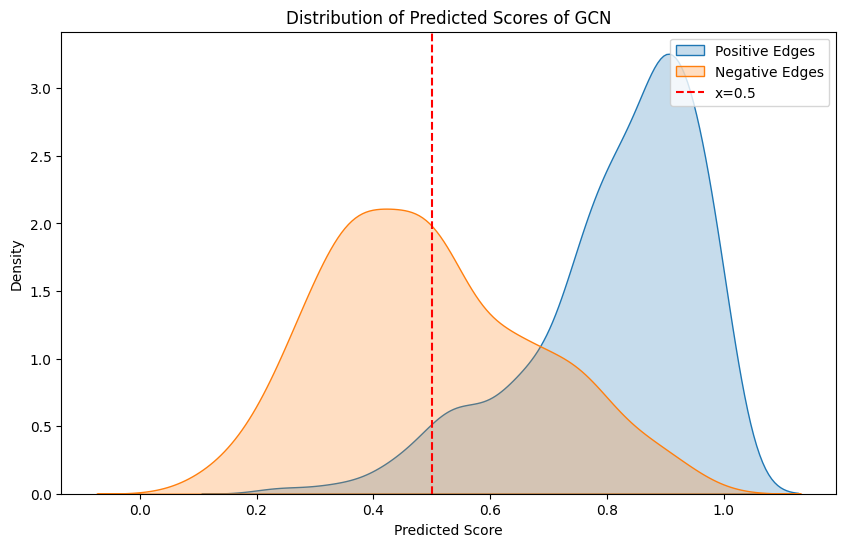

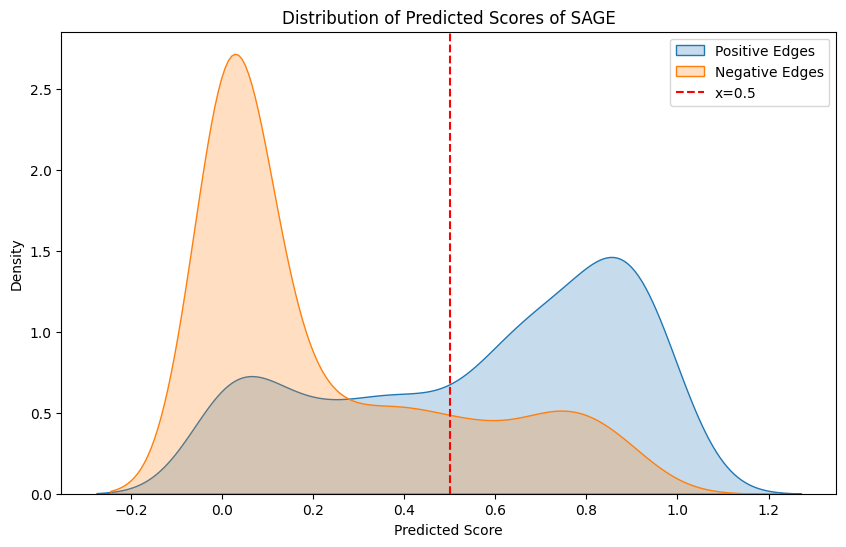

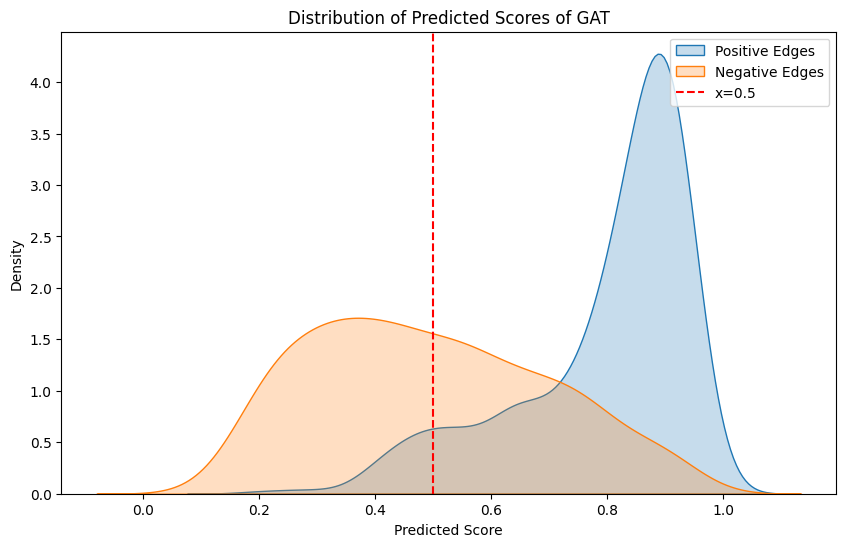

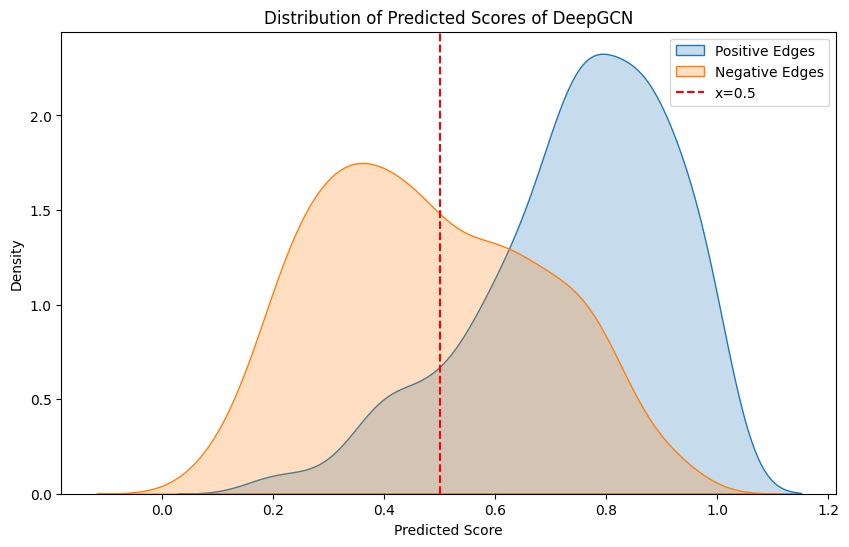

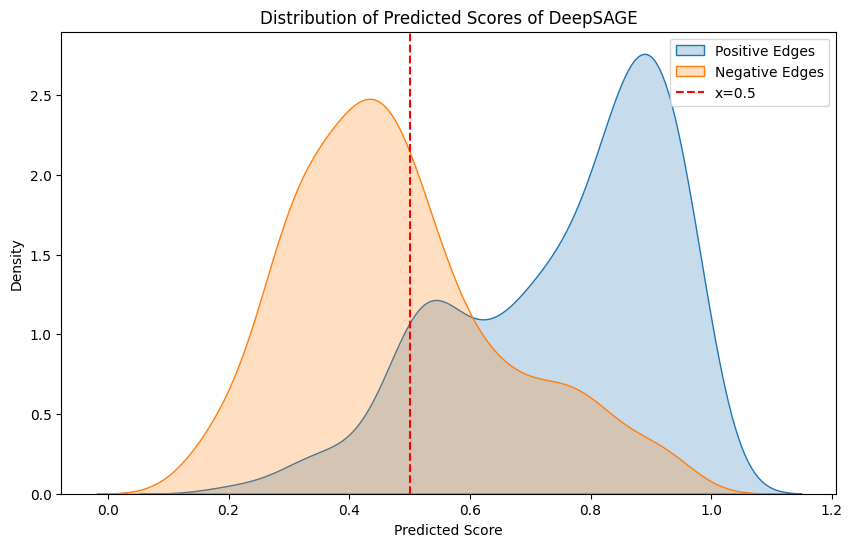

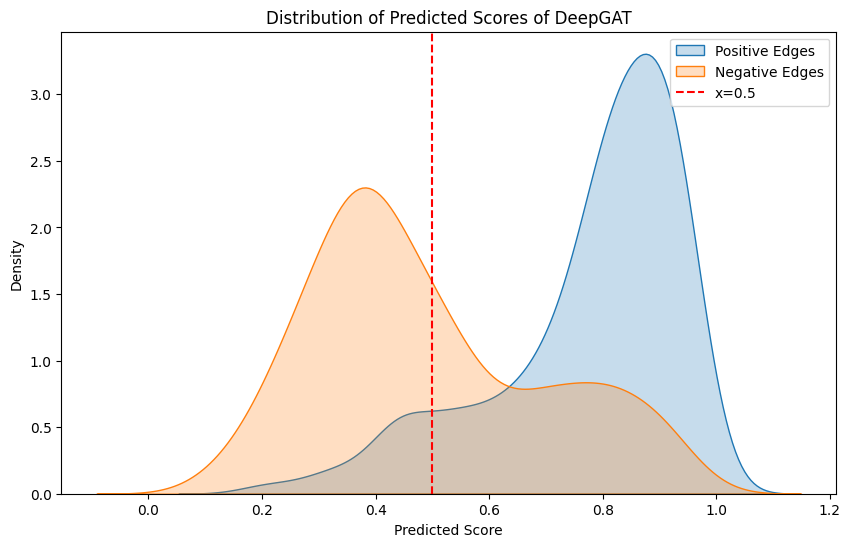

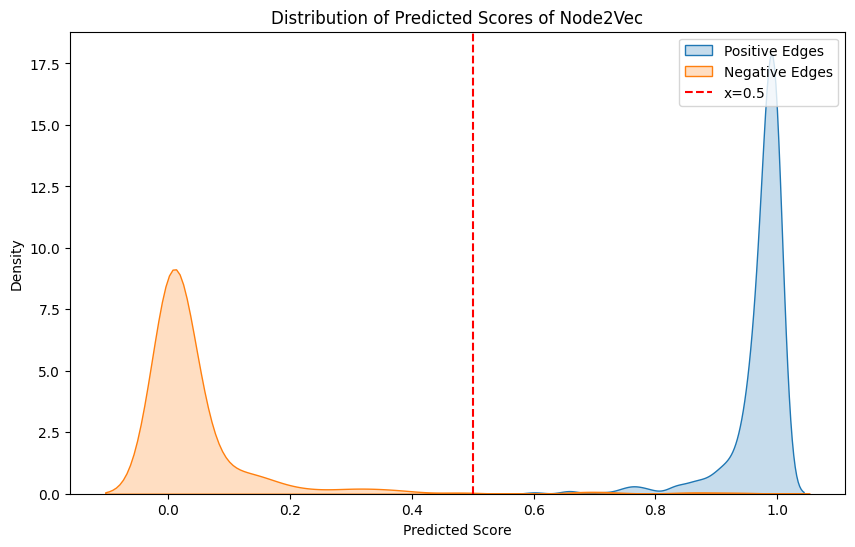

In [ ]:
# function to plot the distribution of predicted scores
def plot_score_distributions(scores, labels, model_name):
    plt.figure(figsize=(10, 6))
    # plot positive edges distribution
    sns.kdeplot(scores[labels == 1], fill=True, label='Positive Edges')
    # plot negative edges distribution
    sns.kdeplot(scores[labels == 0], fill=True, label='Negative Edges')
    # add a vertical line at x = 0.5 for threshold reference
    plt.axvline(x=0.5, color='r', linestyle='--', label='x=0.5')
    plt.xlabel('Predicted Score')
    plt.ylabel('Density')
    plt.title(f'Distribution of Predicted Scores of {model_name}')
    plt.legend()
    model_path = os.path.join(task_path, f'{model_name}')
    # save the plot as an image
    plt.savefig(os.path.join(model_path, 'score_distribution.png'))
    plt.show()

# get test edges and labels
test_edges = edges["test"]
labels = test_edges.edge_label.cpu().numpy()

# iterate over best models and plot score distributions
for model_name, model in best_models_lp.items():
    model.eval()
    with torch.no_grad():
        # get the embeddings and scores from the model
        z = model.encode(test_edges.x, test_edges.edge_index)
        scores = model.decode(z, test_edges.edge_label_index).squeeze().detach().cpu().numpy()
    # plot the score distributions
    plot_score_distributions(scores, labels, model_name)

# get embeddings from Node2Vec model
z = lp.node2vec.get_embeddings()
lp.model.eval()
with torch.no_grad():
    # calculate scores for Node2Vec
    scores = lp.model(z[test_edges.edge_label_index[0]] * z[test_edges.edge_label_index[1]]).squeeze().detach().cpu().numpy()

# plot the score distribution for Node2Vec
plot_score_distributions(scores, labels, "Node2Vec")


<h4> Embeddings Comparison</h4>

FInally, I visualized the embeddings of Node2Vec and compared them with those of my models.

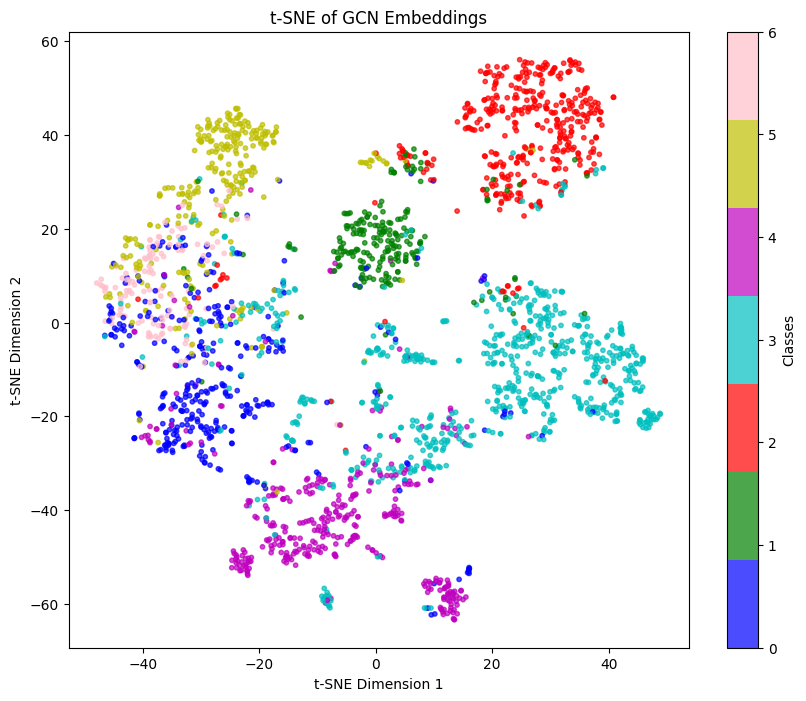

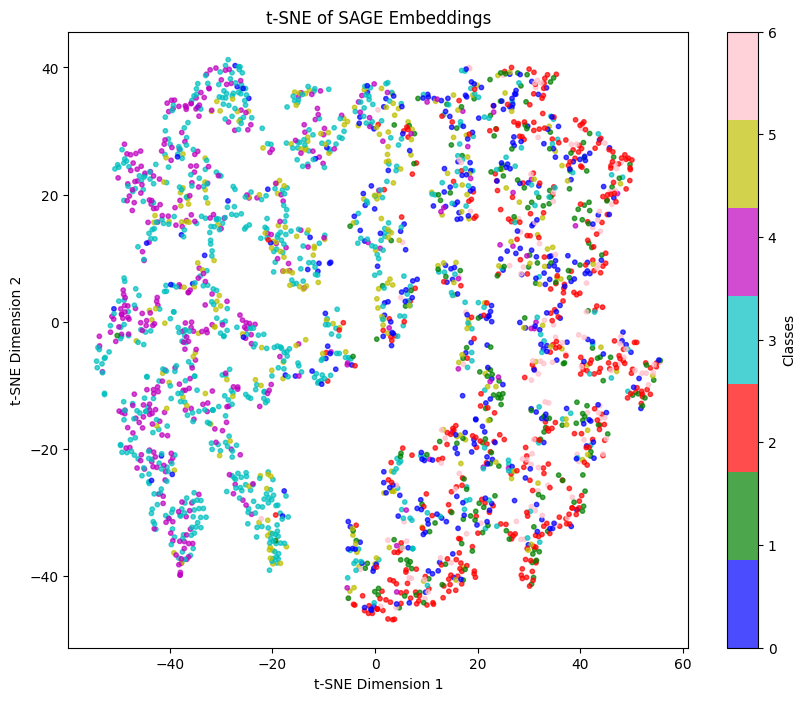

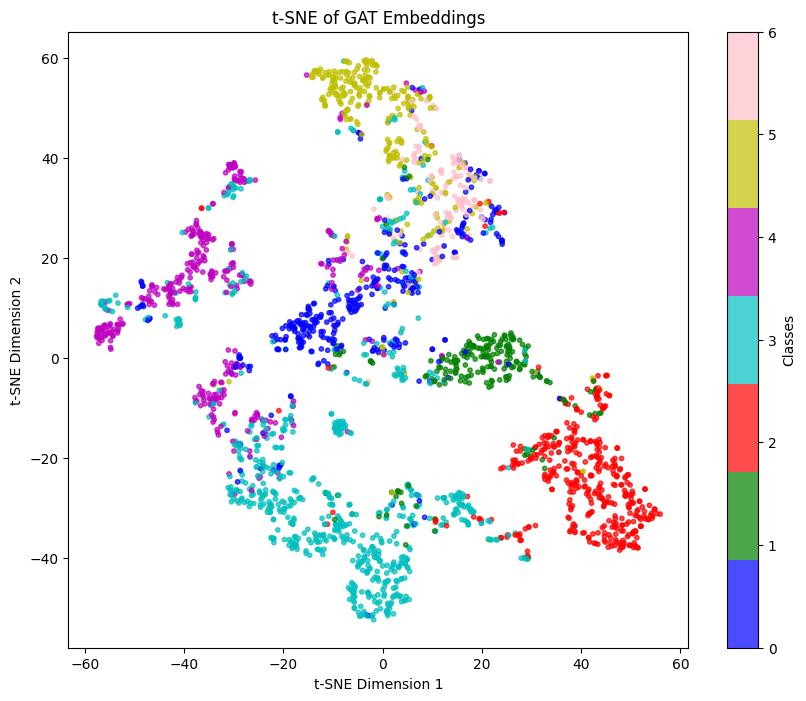

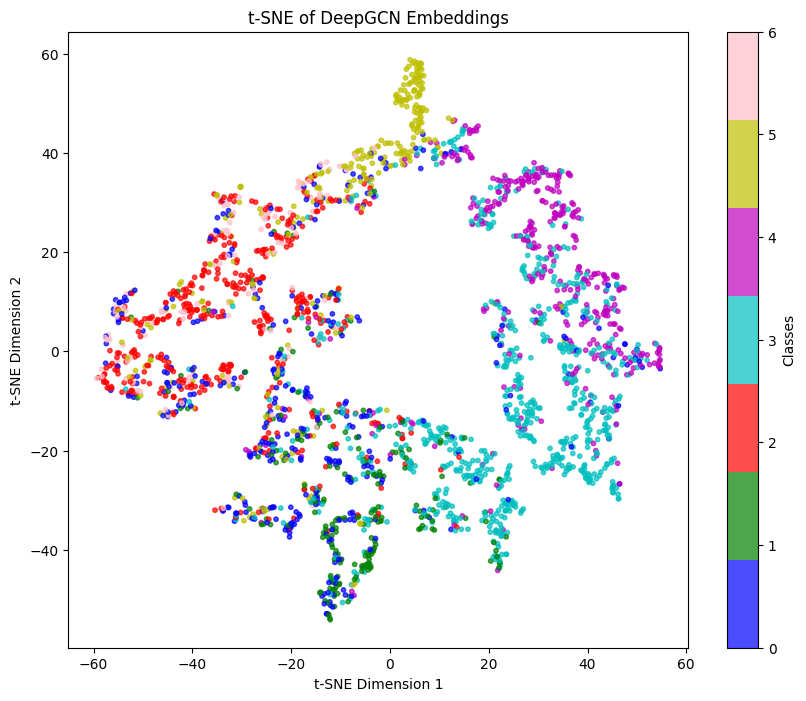

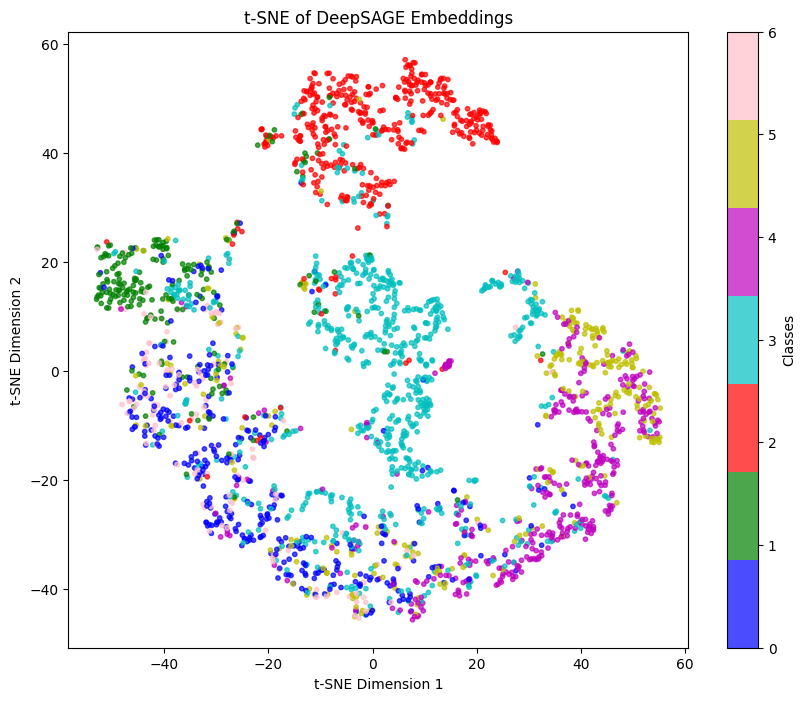

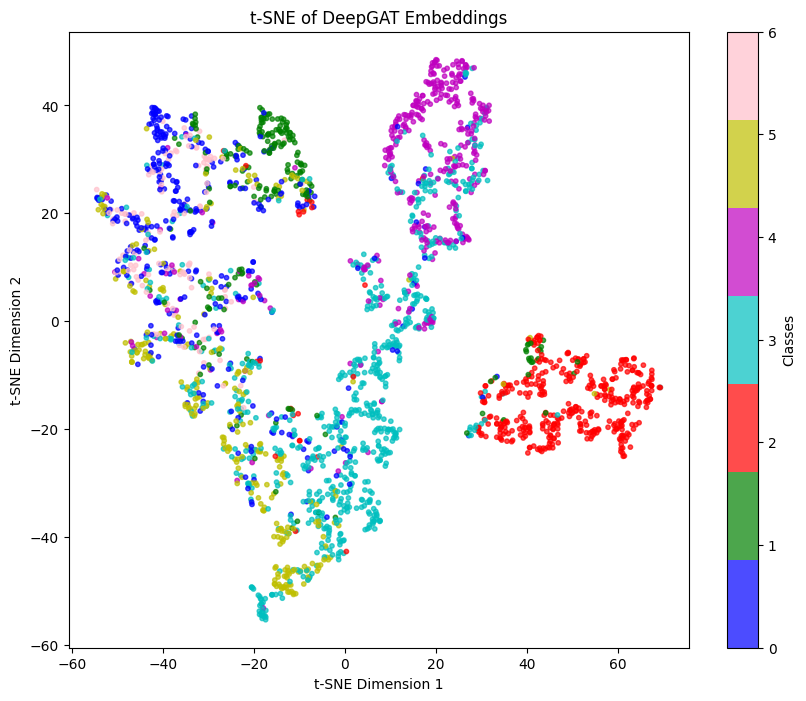

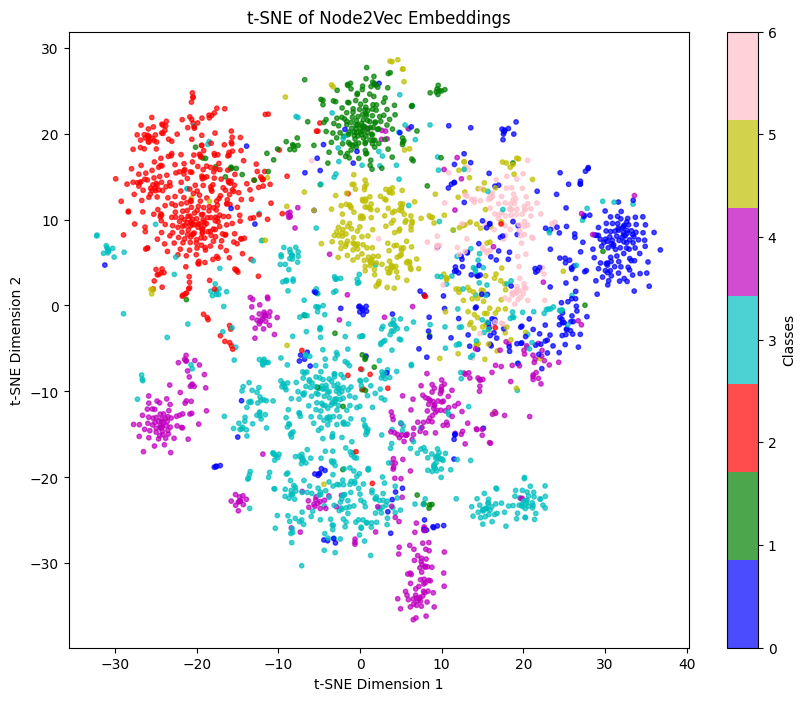

In [ ]:
# set mode to 'tsne' or 'pca' for dimensionality reduction
mode = "tsne"

# iterate over best models and visualize their embeddings
for model_name, model in best_models_lp.items():
    # get embeddings from the model
    embeddings = getEmbeddings(model, dataset, task="LP").cpu().numpy()
    # reduce the embeddings to 2D
    tsne_embeddings = to2d(embeddings, mode)
    # visualize the 2D embeddings
    visualizeEmbeddings(tsne_embeddings, dataset.y.cpu().numpy(), mode, model_name)

# get embeddings from Node2Vec model
embeddings = lp.node2vec.get_embeddings().cpu().numpy()
tsne_embeddings = to2d(embeddings, mode)
visualizeEmbeddings(tsne_embeddings, dataset.y.cpu().numpy(), mode, "Node2Vec")


In [ ]:
best_models_lp

{'GCN': LinkPredictor(
   (embedding): GNNModule(
     (layers): ModuleList()
     (embedding): GCNConv(1433, 128)
     (activ): ReLU()
   )
   (last_conv): GCNConv(128, 32)
   (dropout): Identity()
   (sigmoid): Sigmoid()
 ),
 'SAGE': LinkPredictor(
   (embedding): GNNModule(
     (layers): ModuleList()
     (embedding): SAGEConv(1433, 128, aggr=mean)
     (activ): ReLU()
   )
   (last_conv): SAGEConv(128, 32, aggr=mean)
   (dropout): Identity()
   (mlp): Linear(in_features=32, out_features=1, bias=True)
   (sigmoid): Sigmoid()
 ),
 'GAT': LinkPredictor(
   (embedding): GNNModule(
     (layers): ModuleList()
     (embedding): GATConv(1433, 32, heads=16)
     (activ): ReLU()
   )
   (last_conv): GATConv(512, 16, heads=1)
   (dropout): Identity()
   (sigmoid): Sigmoid()
 ),
 'DeepGCN': LinkPredictor(
   (embedding): GNNModule(
     (layers): ModuleList(
       (0): GNNBlock(
         (conv): GCNConv(1433, 64)
         (dropout): Identity()
         (activation): SiLU()
       )
     )
 